
## Abstract

This project focuses on **composer classification** using deep learning techniques applied to MIDI files. The aim is to build a robust pipeline that processes raw MIDI files, extracts meaningful musical features, and classifies the composer based on the sequence patterns of notes. The approach combines Convolutional Neural Networks (CNN) and Bidirectional LSTM (BiLSTM) layers to effectively capture both local patterns and long-term temporal dependencies in music data. This notebook implements a complete workflow from data preprocessing to model evaluation, providing insights into the effectiveness of hybrid deep learning architectures for music classification.

## Composer Classification

Music composer classification is a complex task in the field of Music Information Retrieval (MIR). While traditional methods rely on hand-crafted features, this project utilizes deep learning to automatically learn meaningful representations directly from musical sequences. The dataset, sourced from this link, includes MIDI files and sheet music of compositions by renowned classical composers such as Bach, Beethoven, Chopin, Mozart, Schubert, and others. Each file is labeled with its corresponding composer, enabling supervised learning for classification.

The MIDI files are processed into sequences of tokens, where each token represents either a note (a single musical sound with pitch and duration) or a chord (multiple notes played simultaneously to form harmony). These tokens capture the musical structure and stylistic patterns of each composition, which are crucial features for the model to learn and accurately determine the composer.


### What Are Notes and Chords?
A note is a single musical sound.

It has:

- A pitch (like C4, A3, etc.)

- A duration (like a quarter note, half note, etc.)

| Term     | Description                                    |
| -------- | ---------------------------------------------- |
| `C4_1.0` | Middle C held for 1 beat (quarter note)        |
| `G5_0.5` | G above middle C for half a beat (eighth note) |



A chord is a group of multiple notes played at the same time.

Often used to express harmony (e.g., major/minor triads).

| Term    | Description                      |
| ------- | -------------------------------- |
| `C-E-G` | C Major chord (root + 3rd + 5th) |
| `0.4.7` | MIDI indices for a C-Major chord |




## Data Processing and Cleansing

The data loading and cleansing phase was designed to handle the complex structure of MIDI files efficiently while ensuring data quality for subsequent modeling. The implemented function load_and_analyze_dataset processes all MIDI files in the dataset directory, extracts meaningful musical features, and ensures that the dataset is both complete and consistent. To achieve optimal performance, a caching mechanism is integrated, which allows the parsed data to be stored locally and reused in subsequent runs without the need for reparsing the entire dataset.

During the loading phase, the function iterates through each composer’s directory, reading every MIDI file using the music21 library. For each file, musical elements such as notes and chords are extracted and tokenized. Tokens are formatted as pitch_duration pairs, capturing both the pitch (e.g., C4, G#) and the note duration. Chords, which consist of multiple notes played simultaneously, are encoded by concatenating their normal-order pitches (e.g., D3.F4.A4) alongside their duration. This tokenization step is critical because it transforms raw musical data into a structured format that can be effectively used in machine learning models.

As part of data augmentation, the transpose_tokens function is applied to generate transposed versions of each token sequence. This transposition shifts pitches by a given number of semitones while preserving rhythmic integrity, effectively increasing dataset diversity and improving model generalization. Five versions of each token sequence are created by applying shifts of -2, -1, 0, +1, and +2 semitones.

The cleansing process includes rigorous error handling to ensure that corrupted or incompatible MIDI files do not disrupt the pipeline. Files that fail to parse or do not produce valid tokens are counted as failed and excluded from further processing. For each composer, the process tracks both successfully loaded and failed files, creating a summary table (df_summary) that provides an overview of data quality. This summary is useful for identifying gaps in the dataset and understanding the completeness of the data.

Finally, the function generates two outputs: df_stats, which stores detailed statistics for each processed file (composer name, file name, and token count), and df_summary, which aggregates success and failure counts per composer. Additionally, the parsed token sequences and associated labels are stored in lists for direct use in model training. All processed results, including token sequences, labels, and statistics, are cached in a pickle file (midi_dataset_cache.pkl) to ensure reproducibility and significantly reduce processing time in future executions. This systematic approach to data loading and cleansing ensures that the dataset used in this project is both reliable and enriched with augmented samples, forming a strong foundation for downstream modeling and analysis.


## Exploratory Data Analysis (EDA)


To ensure the dataset was suitable for deep learning, an extensive exploratory data analysis (EDA) was conducted. This analysis provided an in-depth understanding of the dataset’s structure, highlighted potential inconsistencies, and guided decisions for data preprocessing and model preparation.

The process began by examining how well the dataset had been loaded. During the parsing stage, each composer’s folder was scanned, and files were either successfully processed or marked as failed if they could not be parsed correctly. This information was aggregated and visualized using a grouped bar chart, offering an immediate overview of data integrity. By observing this, it became evident which composers had robust datasets and which ones suffered from missing or unusable files. This step was particularly valuable for determining whether additional data collection or augmentation would be required to balance the dataset.

The next focus was on the distribution of sequences per composer. Each MIDI file was transformed into a series of tokens, and the length of these tokenized sequences reflected the complexity of the composition. By plotting the number of sequences per composer, we assessed whether the dataset was evenly distributed or skewed toward specific composers. Any imbalance in the number of sequences could bias the model, making this analysis a crucial part of data preparation.

To further characterize the data, we explored token count statistics. Summary metrics such as mean, median, and percentiles were calculated, giving a clear picture of the average sequence length and the spread of values. These statistics were complemented by a histogram that visualized the overall token count distribution. A 95th percentile line was added to help identify sequences that were unusually long. This information later proved essential for determining suitable sequence length parameters during model training.

We also compared sequence lengths across composers using a boxplot, which provided insight into differences in musical complexity among the composers. Some composers consistently produced longer or shorter sequences, and this variation was important to consider because it could influence how the model interprets stylistic differences in music.

Lastly, an outlier analysis was performed using the interquartile range (IQR) method. Outliers were sequences with token counts that were significantly different from the rest of the data. These cases were carefully reviewed because they could either be noise (e.g., parsing errors) or musically meaningful exceptions. Their identification allowed us to decide whether to keep them for training or handle them separately.

This EDA played a critical role in shaping the subsequent stages of the project. It allowed us to:

- Confirm data reliability by quantifying the proportion of successfully loaded files for each composer.

- Assess dataset balance, revealing whether some composers were over- or under-represented.

- Understand sequence characteristics, which directly influenced preprocessing decisions such as padding, truncation, and normalization.

- Detect anomalies that could either enrich the dataset or negatively impact training if left untreated.

Through this process, several key findings emerged. Some composers had higher failure rates, indicating gaps in their data representation. Token counts varied considerably, confirming stylistic diversity between composers. Additionally, a few extreme outliers were identified, which required careful handling during preprocessing. These insights collectively informed decisions about data augmentation (such as transposition), normalization strategies, and model architecture, ensuring that the dataset was well-prepared for building an accurate and generalizable classification model.

## Model Architecture


The model designed for this project is a hybrid deep learning architecture that combines Convolutional Neural Networks (CNNs) and Bidirectional Long Short-Term Memory (BiLSTM) layers, enhanced with an Attention mechanism. This combination leverages the strengths of both CNNs and LSTMs to effectively process tokenized sequences derived from MIDI data, enabling the network to capture both local musical patterns and long-range dependencies in the compositions.

### Role of CNN in the Model

The CNN layers in the model act as feature extractors. They process the embedded token sequences and learn to detect local patterns within the data. In the context of MIDI token sequences, these patterns could correspond to short sequences of notes, rhythmic motifs, or chord progressions that frequently occur in the music of specific composers.

- Convolutional Layers (with filters of different sizes) allow the model to learn multiple types of local features simultaneously.

- MaxPooling Layers downsample the feature maps, reducing dimensionality while retaining the most important information.

- This hierarchical extraction of features helps the network capture low-level musical structures before passing the data to recurrent layers.

By applying CNN at the initial stage, the model efficiently reduces noise and highlights meaningful features, which makes subsequent LSTM processing more effective.


### Role of BiLSTM in the Model
After extracting local features, the model uses a Bidirectional LSTM (BiLSTM) to capture temporal dependencies in both forward and backward directions. MIDI music is inherently sequential, where the meaning of a note or chord often depends on the preceding and following context.

- LSTM units are capable of learning long-range dependencies, addressing the vanishing gradient problem that limits standard RNNs.

- The bidirectional setup allows the model to consider both past and future musical context when analyzing a sequence, resulting in richer representations of the musical structure.

- This is particularly valuable in composer classification because a composer’s style is often defined not just by isolated notes but by how patterns evolve throughout a piece.

The BiLSTM thus provides the model with a deep understanding of temporal dynamics within each composition.

### Enhancement with Attention Mechanism

The inclusion of an Attention layer further strengthens the model. After the BiLSTM processes the sequence, attention allows the model to focus selectively on the most relevant parts of the sequence when making predictions. Rather than treating all time steps equally, the network learns which notes or patterns are most 
indicative of the composer’s style.




## Training

During the model training, the team experimented with various sequence lengths to identify the optimal value that maximizes model performance. As shown in the plot, shorter sequence lengths initially yielded moderate accuracy, but there was a noticeable drop at a length of around 300. Beyond this point, increasing the sequence length consistently improved validation accuracy, with the highest performance achieved at a length of approximately 1280. These results suggest that longer sequences provide richer contextual information, enabling the model to capture more complex patterns in the musical data and leading to better classification accuracy.


<img src="/Users/ajaykamble/Desktop/AAI-511/project/sequence.png" style="width:50%; height:auto;">

<img src="/Users/ajaykamble/Desktop/AAI-511/project/output.png" style="width:100%; height:auto;">

The confusion matrices confirm that longer sequence lengths allow the model to capture richer musical context, leading to fewer misclassifications and higher overall accuracy. However, improvements were uneven across composers, with certain classes still prone to confusion due to overlapping stylistic features. The best performance was achieved at a sequence length of 1280, where both overall accuracy and per-class consistency were maximized.


The model leveraged several techniques to improve performance and generalization across composers. Class weights were incorporated directly into the loss function, giving higher importance to underrepresented composers. This ensured that the model penalized misclassifications of minority classes more strongly, preventing bias toward composers with larger sample sizes and enhancing overall classification balance.

The model architecture began with an embedding layer that transformed tokenized notes and chords into dense vector representations, capturing meaningful relationships between musical elements. These embeddings were processed through multiple 1D convolutional layers (Conv1D) with varying filter sizes and kernel configurations, followed by max-pooling layers to extract hierarchical features while reducing dimensionality. The team experimented with different kernel sizes to capture musical patterns at multiple scales—smaller kernels highlighted local note transitions, while larger kernels captured broader harmonic and rhythmic structures.

To further improve robustness, data augmentation was applied by transposing musical sequences. Using a transposition function, each tokenized sequence (consisting of notes and chords) was shifted up or down by a few semitones while preserving the original musical relationships. This increased data diversity without altering stylistic characteristics, allowing the model to better capture invariant patterns across different pitch ranges.

Together, these strategies—class weighting, kernel size experimentation, and pitch transposition-based augmentation—significantly enhanced the model’s ability to learn composer-specific features and generalize effectively to unseen data.



## Implementation

### Import Packages
Following are thenecessary libraries for the project:

- **os, numpy, pandas** for file handling and data processing.

- **matplotlib, seaborn** for data visualization.

- **music21** for MIDI file parsing and feature extraction.

- **scikit-learn** for preprocessing and evaluation metrics.

- **TensorFlow/Keras** for building and training the deep learning models.

These imports set up the foundation for the entire pipeline.

In [1]:
import os
import pickle
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from music21 import converter, instrument, note, chord

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.utils import class_weight
from sklearn.utils import class_weight
from sklearn.manifold import TSNE

import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Bidirectional, Attention, GlobalAveragePooling1D, LayerNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model



### Parameter Setup
This section defines key parameters such as dataset directories, maximum sequence length, batch size, and number of training epochs. These parameters control the flow of data and the computational load during training. The choice of `MAX_SEQ_LENGTH` ensures that all sequences are of uniform length, while `BATCH_SIZE` and `EPOCHS` are tuned to balance training time with model convergence.

In [2]:

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

DATASET_DIR = "Composer_Dataset/NN_midi_files_extended/train"
TESTSET_DIR = "Composer_Dataset/NN_midi_files_extended/test"
CACHE_FILE = "midi_dataset_cache.pkl"
MAX_SEQ_LENGTH = 1280
BATCH_SIZE = 16
EPOCHS = 30

### Data Loading and Parsing

In [3]:
def transform_pitch(pitch, steps):
    """Shift a pitch or chord by the given steps."""

    return ('.'.join(str(int(n) + steps) for n in pitch.split('.'))
            if "." in pitch else str(note.Note(pitch).transpose(steps).nameWithOctave))

def transpose_sequence(tokens, steps):
    """Functional approach: transpose all tokens by semitone steps."""
    
    def process(token):
        try:
            pitch, dur = token.split("_", 1)
            return f"{transform_pitch(pitch, steps)}_{dur}"
        except Exception:
            return None

    return list(filter(None, map(process, tokens)))


def load_and_analyze_dataset(root_dir, use_cache=True, save=True):
    """Load MIDI dataset once, parse it, and cache results with success/failure counts."""

    # --- Load from cache ---
    if use_cache and os.path.exists(CACHE_FILE):
        print(f"[INFO] Loading dataset from cache: {CACHE_FILE}")
        with open(CACHE_FILE, "rb") as f:
            cached_data = pickle.load(f)
        return cached_data["df_stats"], cached_data["token_sequences"], cached_data["composer_labels"], cached_data["composer_summary"]

    print("[INFO] Parsing MIDI files... This may take time.")

    composer_stats, lengths, token_sequences, composer_labels = [], [], [], []
    composer_summary = [] 

    for composer in sorted(os.listdir(root_dir)):
        composer_dir = os.path.join(root_dir, composer)

        if not os.path.isdir(composer_dir):
            continue

        success_count, fail_count = 0, 0
        
        for fname in sorted(os.listdir(composer_dir)):
        
            if fname.lower().endswith(('.mid', '.midi')):
        
                file_path = os.path.join(composer_dir, fname)
        
                try:
                    midi = converter.parse(file_path)
                    parts = instrument.partitionByInstrument(midi)
                    elements = parts.parts[0].recurse() if parts else midi.flat.notes

                    raw_tokens = []
        
                    for el in elements:
        
                        if isinstance(el, note.Note):
                            raw_tokens.append(f"{el.pitch}_{el.quarterLength}")
                        elif isinstance(el, chord.Chord):
                            chord_symbol = '.'.join(str(n) for n in el.normalOrder)
                            raw_tokens.append(f"{chord_symbol}_{el.quarterLength}")

                    if not raw_tokens:
                        fail_count += 1
                        continue

                    # Collect statistics 
                    composer_stats.append({"Composer": composer, "File": fname, "Token_Count": len(raw_tokens)})
                    lengths.append(len(raw_tokens))

                    # Store tokens (original + transpositions) 
                    for shift in [-2, -1, 0, 1, 2]:
                        transposed = transpose_sequence(raw_tokens, shift) if shift != 0 else raw_tokens
                        token_sequences.append(transposed)
                        composer_labels.append(composer)

                    success_count += 1

                except Exception as e:
                    fail_count += 1
                    #logging.warning(f"[Warning] Failed to process {file_path}: {e}")

        composer_summary.append({
            "Composer": composer,
            "Files_Success": success_count,
            "Files_Failed": fail_count,
            "Total_Files": success_count + fail_count
        })

    # Create DataFrames
    df_stats = pd.DataFrame(composer_stats)
    df_summary = pd.DataFrame(composer_summary)

    # Cache all results
    cache_data = {
        "df_stats": df_stats,
        "token_sequences": token_sequences,
        "composer_labels": composer_labels,
        "composer_summary": df_summary
    }
    if(save := True):
        print(f"[INFO] Saving dataset cache to: {CACHE_FILE}")
        with open(CACHE_FILE, "wb") as f:
            pickle.dump(cache_data, f)

    print(f"[INFO] Dataset cached at: {CACHE_FILE}")
    

    return df_stats, token_sequences, composer_labels, df_summary



### Supporting function for EDA


In [4]:
def perform_eda(df_stats, token_sequences, composer_labels, df_summary):
    """Perform EDA on the loaded dataset, including success/failure file counts."""

    print("\n### Composer File Load Summary ###")
    print(df_summary)

    # Plot Success vs Failure per Composer
    plt.figure(figsize=(10, 6))
    df_summary_melted = df_summary.melt(id_vars="Composer", value_vars=["Files_Success", "Files_Failed"],
                                        var_name="Status", value_name="Count")
    sns.barplot(x="Composer", y="Count", hue="Status", data=df_summary_melted,
                palette={"Files_Success": "seagreen", "Files_Failed": "tomato"})
    plt.xticks(rotation=45)
    plt.title("Files Loaded Successfully vs Failed per Composer")
    plt.tight_layout()
    plt.show()

    # Build Token Count DataFrame
    eda_df = pd.DataFrame({
        "Composer": composer_labels,
        "Token_Count": [len(seq) for seq in token_sequences]
    })

    print("\n### Basic Dataset Info ###")
    print(eda_df.info())
    print("\n### First 5 Rows ###")
    print(eda_df.head())

    # Class Distribution (Colorful)
    plt.figure(figsize=(12, 5))
    sns.countplot(x="Composer", data=eda_df, order=eda_df["Composer"].value_counts().index,
                  palette="Set2")
    plt.xticks(rotation=45)
    plt.title("Distribution of Sequences per Composer")
    plt.tight_layout()
    plt.show()

    # Token Count Statistics
    print("\n### Token Count Statistics ###")
    print(eda_df["Token_Count"].describe())

    # Token Count Histogram (Colorful)
    plt.figure(figsize=(10, 6))
    sns.histplot(eda_df["Token_Count"], bins=40, kde=True, color="royalblue")
    plt.axvline(np.percentile(eda_df["Token_Count"], 95), color='red', linestyle='--', label='95th percentile')
    plt.title("Distribution of Token Counts per Sequence")
    plt.xlabel("Token Count")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

    # Composer-wise Token Length Distribution (Colorful)
    plt.figure(figsize=(14, 7))
    sns.boxplot(x="Composer", y="Token_Count", data=eda_df, palette="Set3")
    plt.xticks(rotation=45)
    plt.title("Token Count Distribution by Composer")
    plt.tight_layout()
    plt.show()

    # Outlier Detection 
    q1, q3 = eda_df["Token_Count"].quantile([0.25, 0.75])
    iqr = q3 - q1
    upper, lower = q3 + 1.5 * iqr, q1 - 1.5 * iqr
    outliers = eda_df[(eda_df["Token_Count"] > upper) | (eda_df["Token_Count"] < lower)]

    print(f"\n### Outliers in Token Count ###\nFound {len(outliers)} outliers:")
    print(outliers.head())


### Load Dataset

This line calls the custom function load_dataset to load and preprocess the dataset stored in the directory specified by DATASET_DIR. The function scans the dataset folder, reads all MIDI files, and extracts their corresponding token sequences (lists of musical note-duration tokens) along with composer labels (the composer associated with each file). The returned values are:

token_sequences – a list of tokenized musical sequences, where each sequence represents a composition as a series of note events.

composer_labels – a list of labels indicating the composer of each sequence.

This separation of musical content (features) and composer identity (labels) is essential for supervised learning, where the model learns to map sequences to their correct composer.

[INFO] Loading dataset from cache: midi_dataset_cache.pkl

### Composer File Load Summary ###
      Composer  Files_Success  Files_Failed  Total_Files
0         bach             42             0           42
1       bartok             32             9           41
2         byrd             42             0           42
3       chopin             36             5           41
4       handel             12            29           41
5       hummel             21            21           42
6  mendelssohn             14            27           41
7       mozart             14            27           41
8     schumann             32             6           38


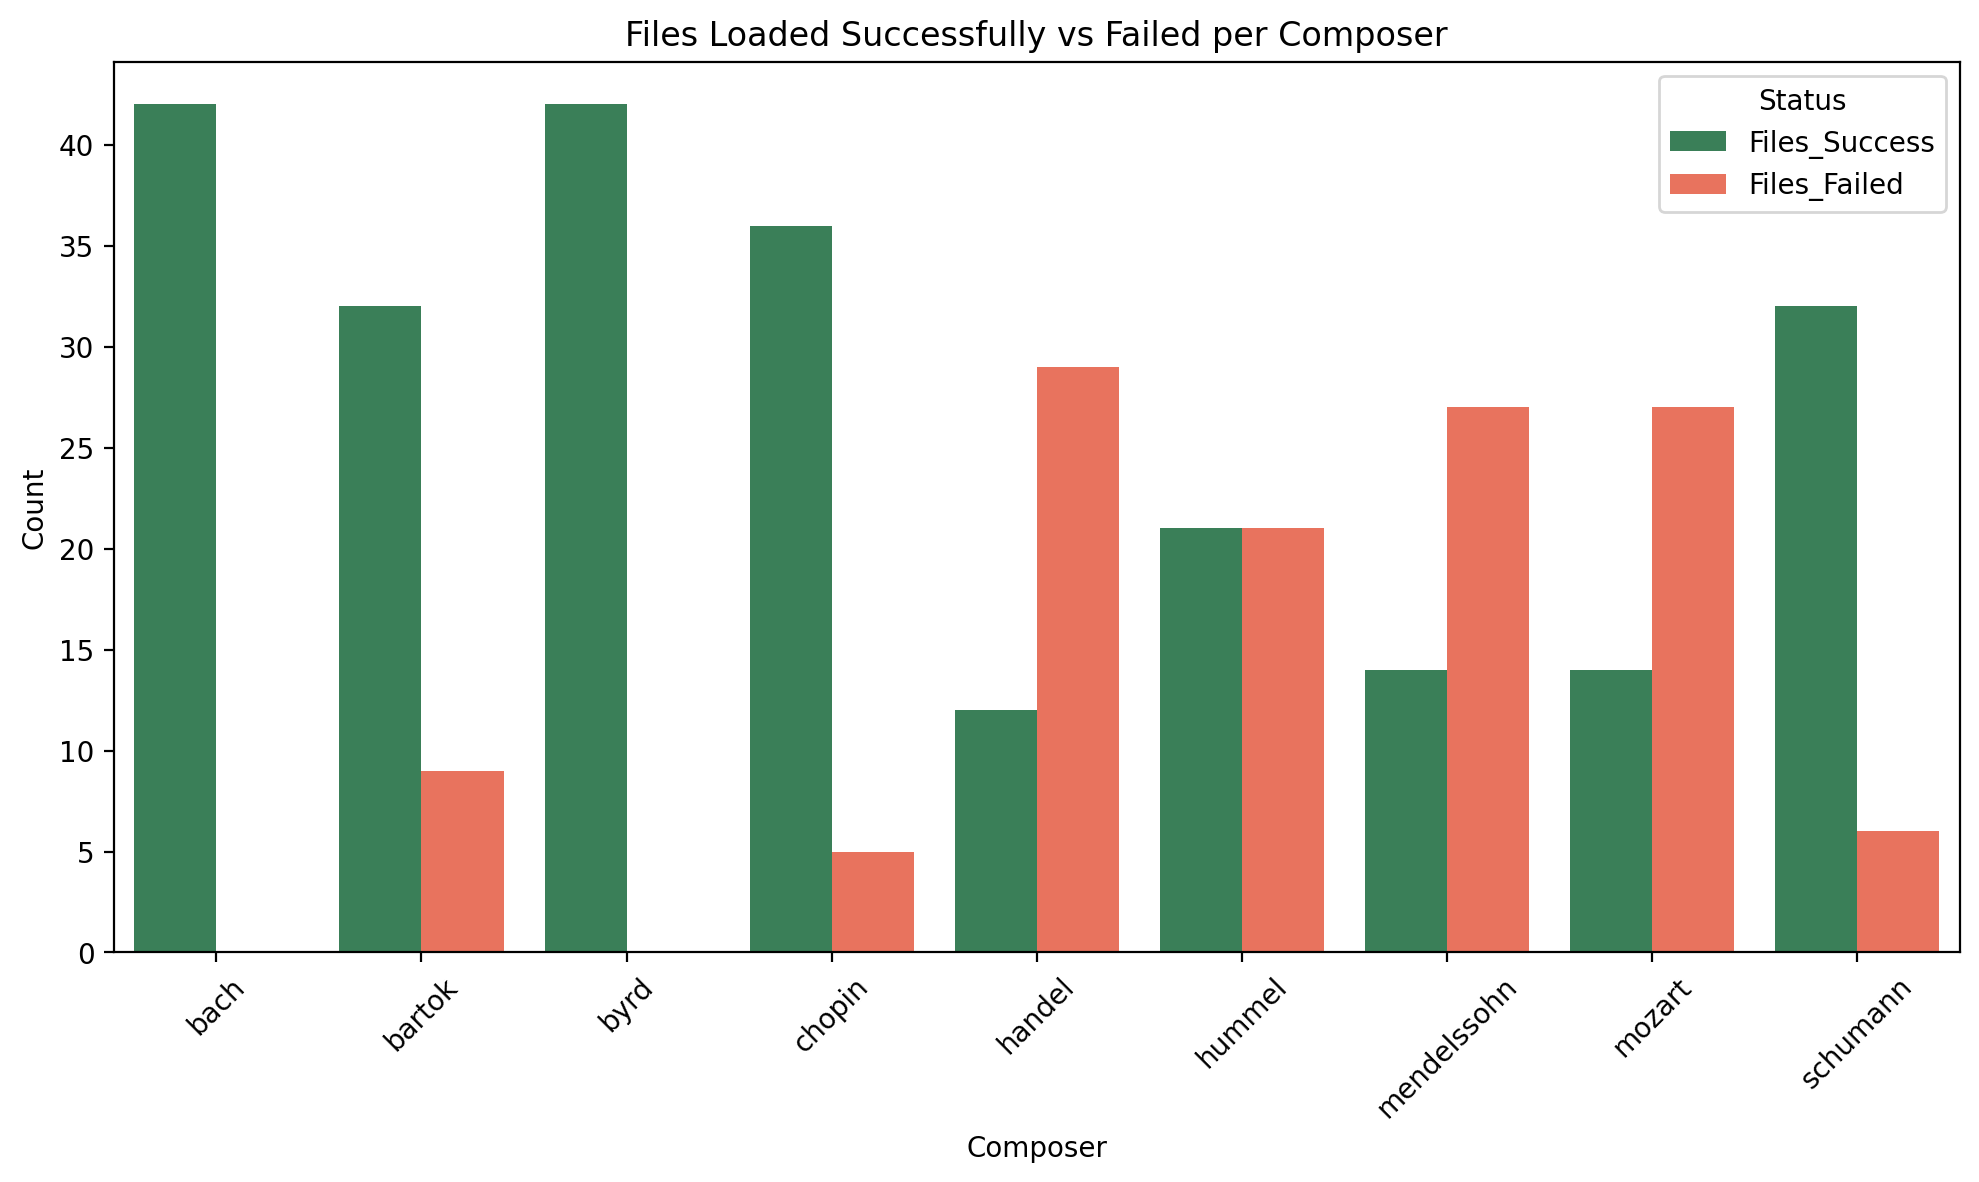


### Basic Dataset Info ###
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1225 entries, 0 to 1224
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Composer     1225 non-null   object
 1   Token_Count  1225 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 19.3+ KB
None

### First 5 Rows ###
  Composer  Token_Count
0     bach         5277
1     bach         5277
2     bach         5392
3     bach         5277
4     bach         5277


/var/folders/lr/13yws9cx1v7bl1kl2lgn8c_m0000gn/T/ipykernel_76872/3872771092.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Composer", data=eda_df, order=eda_df["Composer"].value_counts().index,


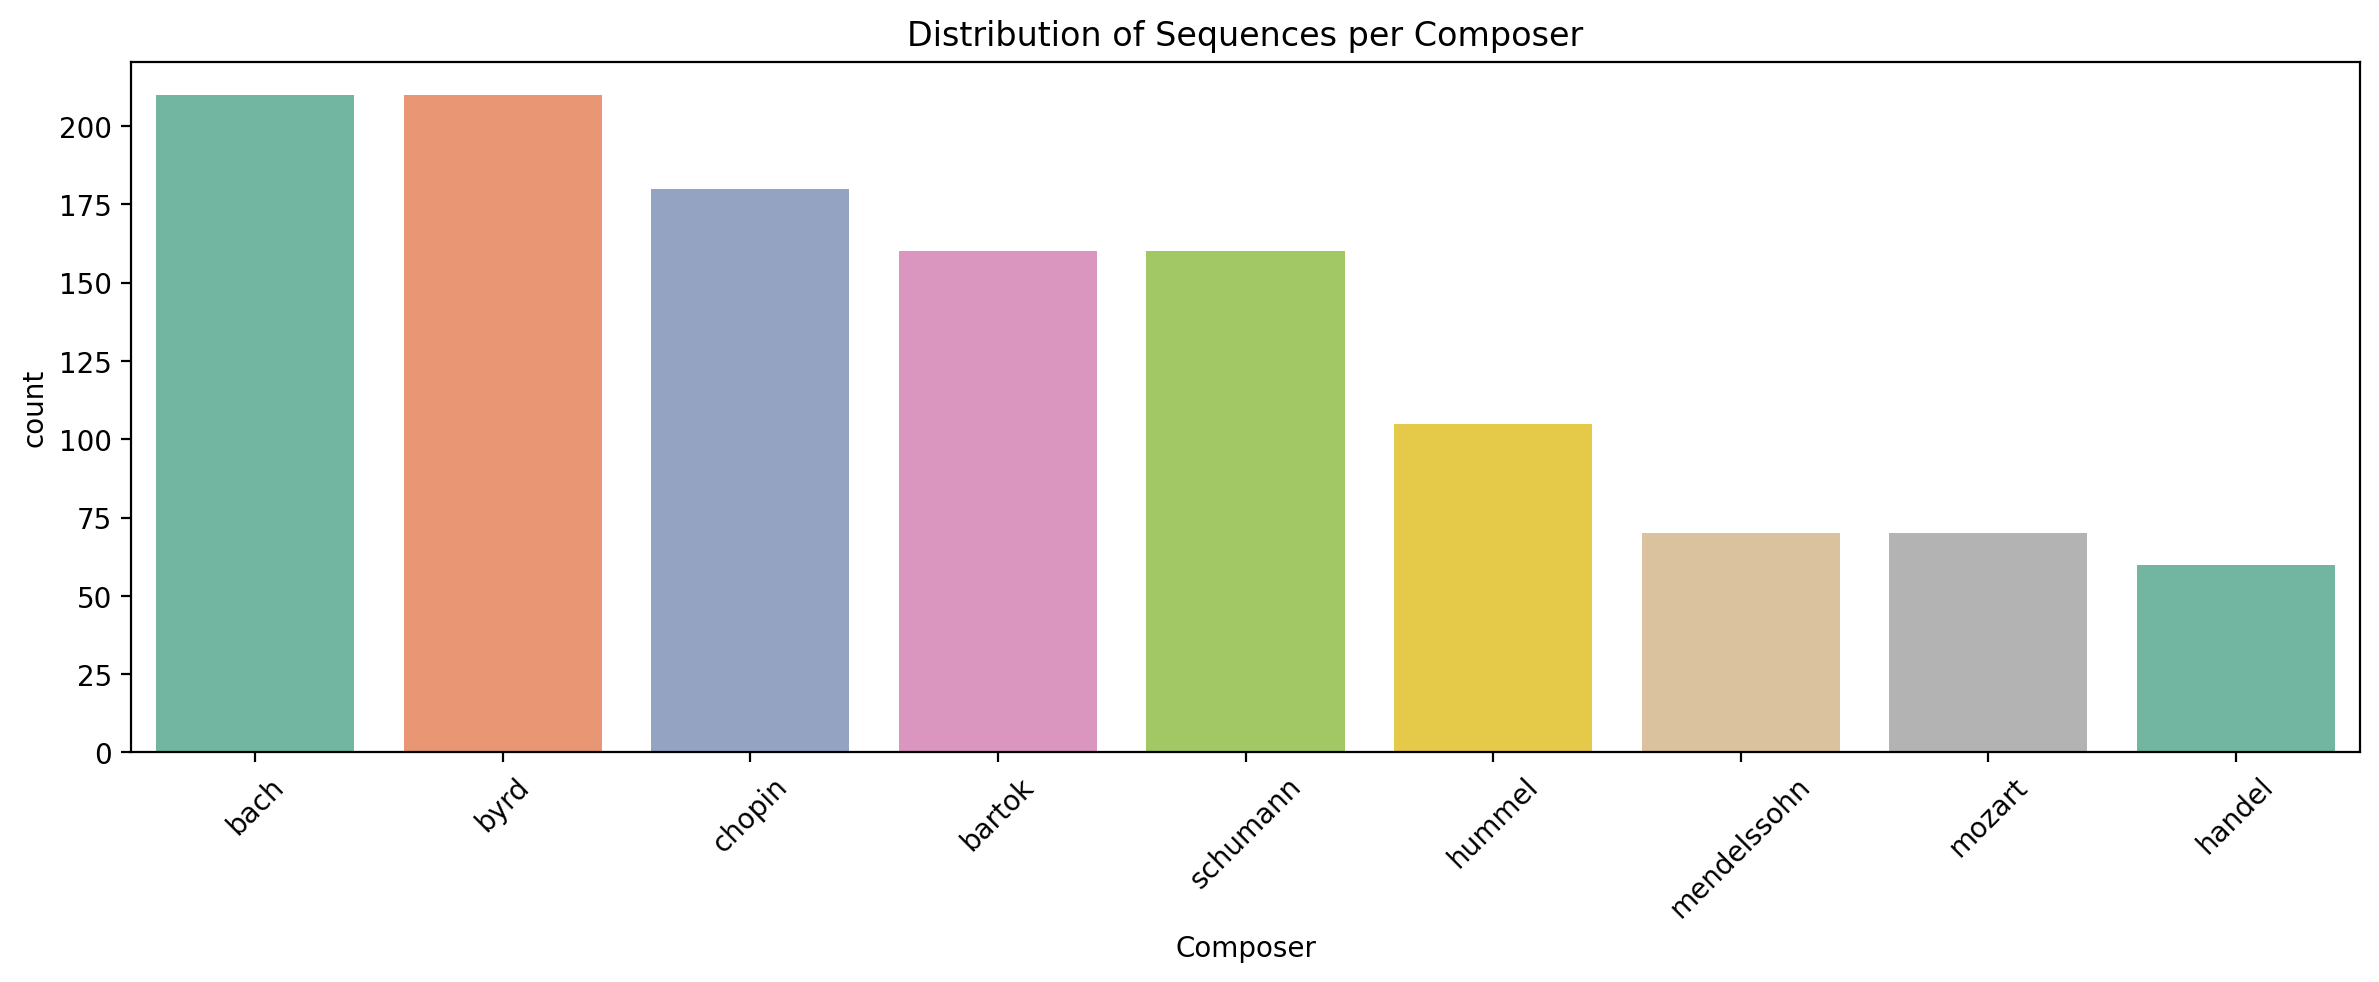


### Token Count Statistics ###
count     1225.000000
mean      1493.400816
std       1920.963346
min         92.000000
25%        487.000000
50%        886.000000
75%       1757.000000
max      16133.000000
Name: Token_Count, dtype: float64


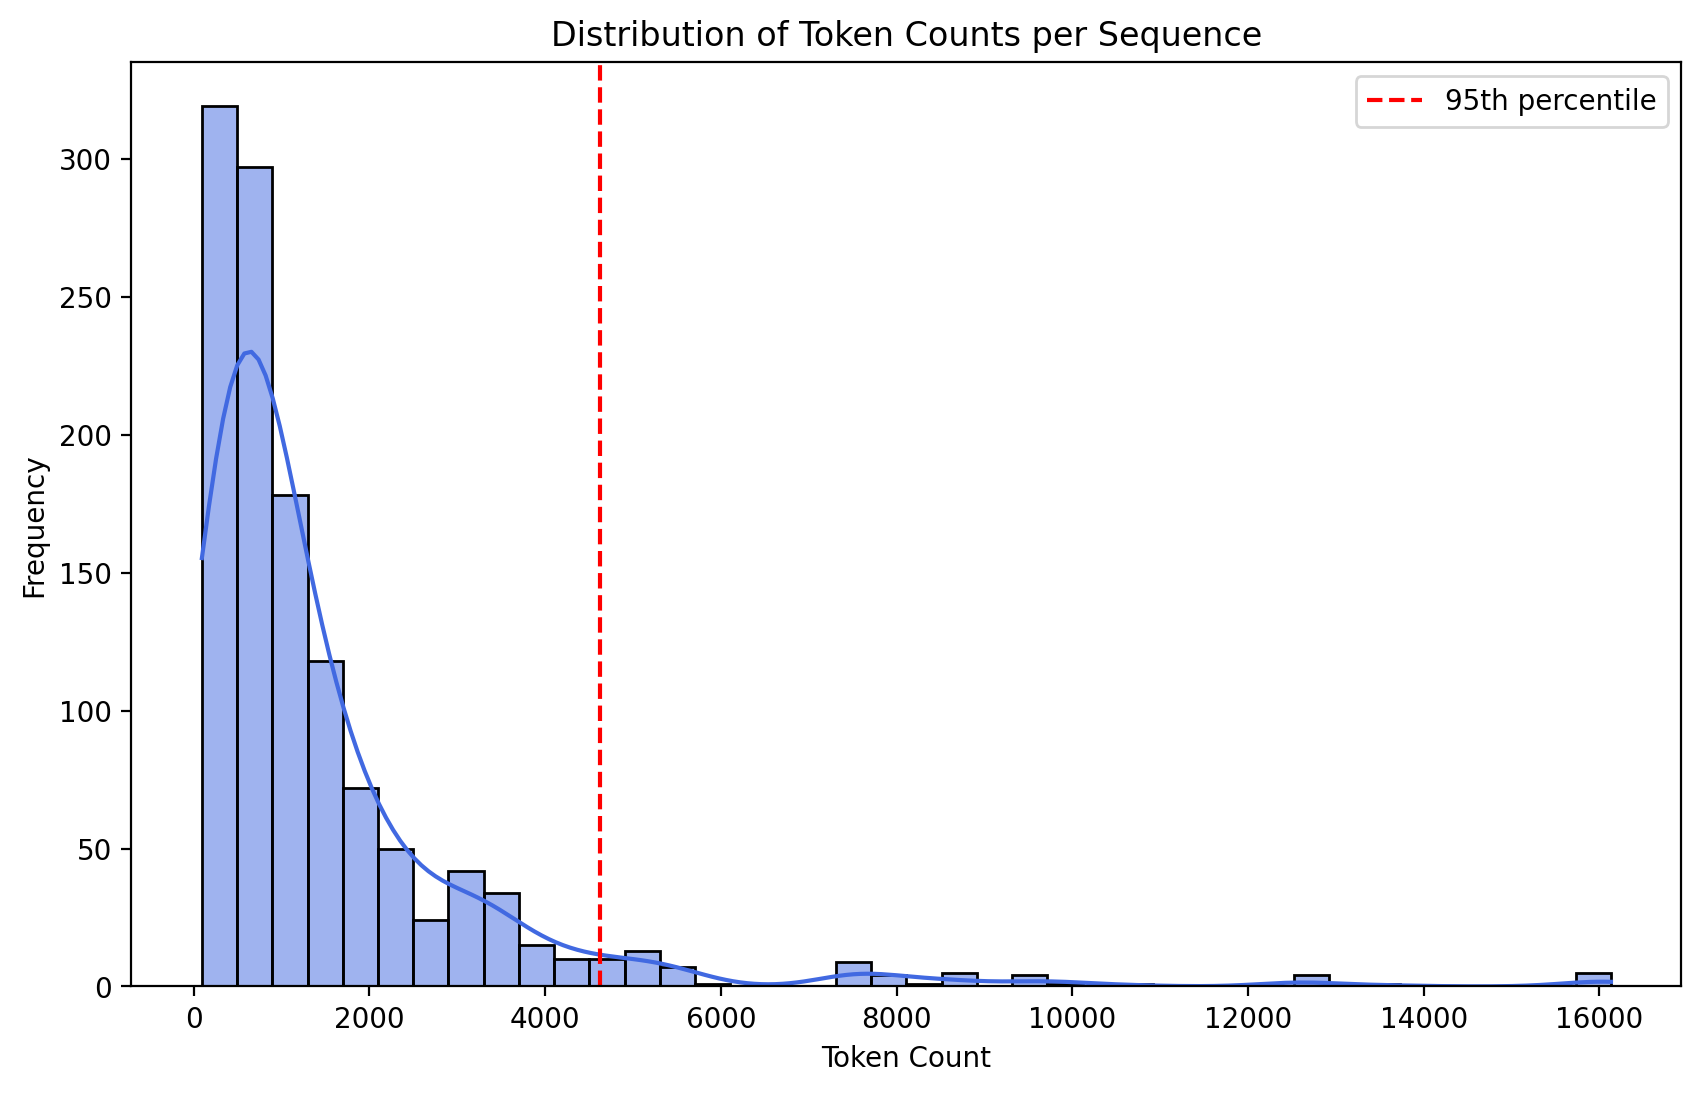

/var/folders/lr/13yws9cx1v7bl1kl2lgn8c_m0000gn/T/ipykernel_76872/3872771092.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Composer", y="Token_Count", data=eda_df, palette="Set3")


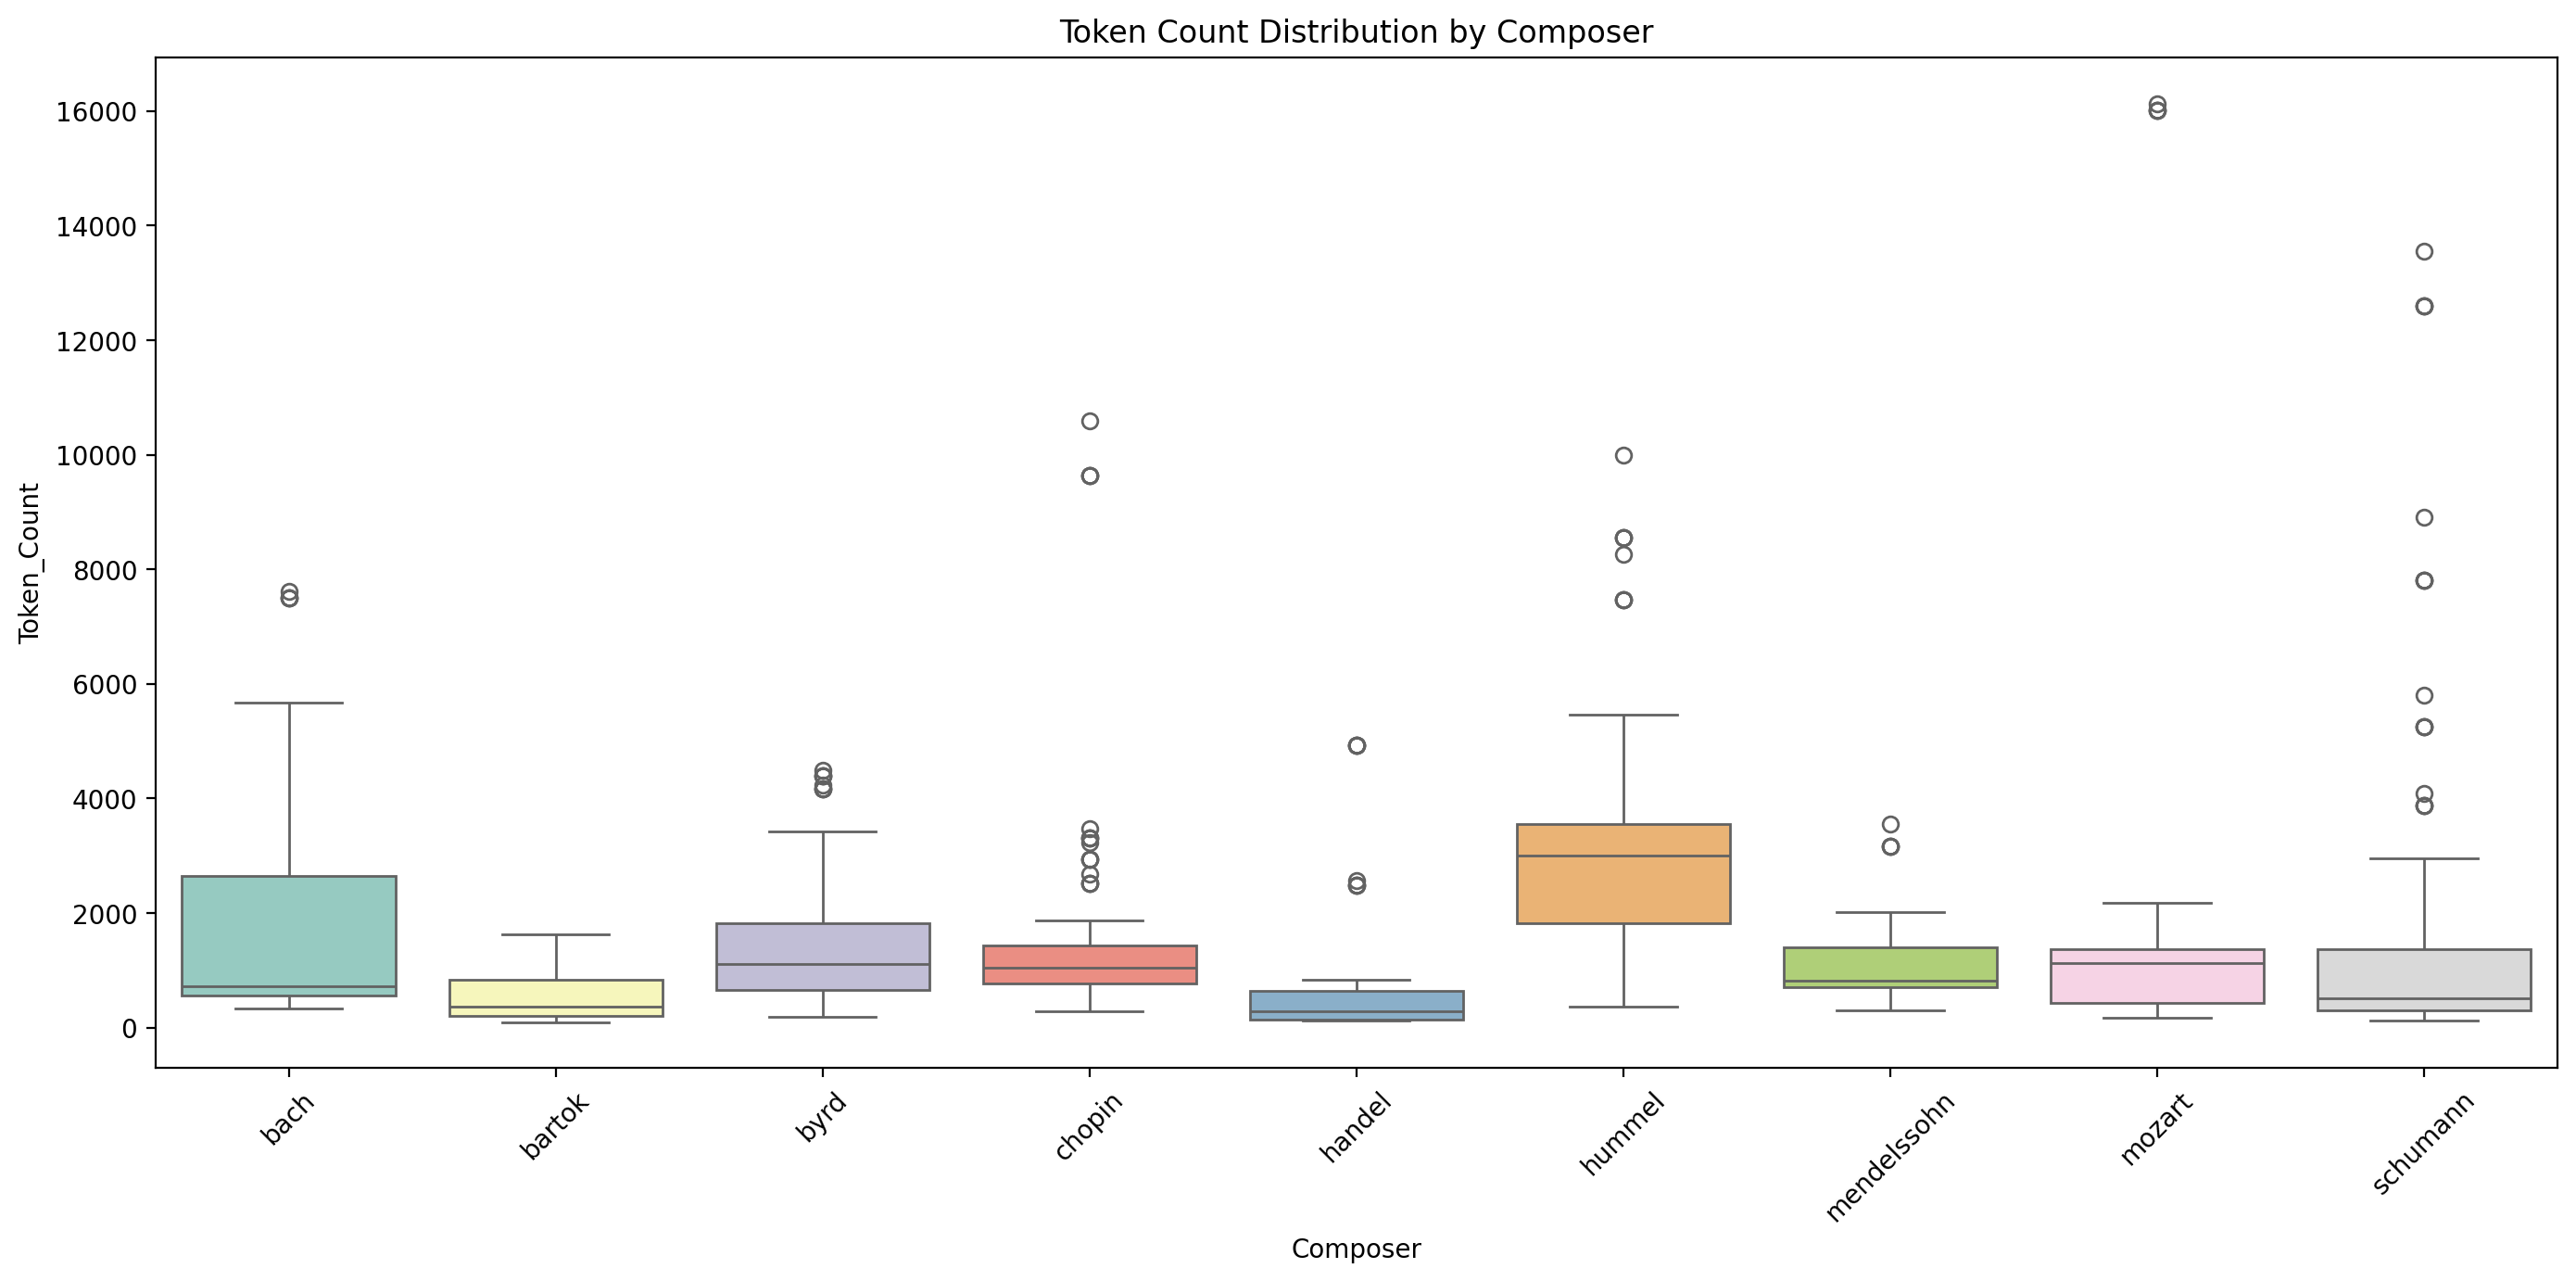


### Outliers in Token Count ###
Found 96 outliers:
  Composer  Token_Count
0     bach         5277
1     bach         5277
2     bach         5392
3     bach         5277
4     bach         5277


In [5]:

df_stats, token_sequences, composer_labels, df_summary = load_and_analyze_dataset(DATASET_DIR, use_cache=True)
perform_eda(df_stats, token_sequences, composer_labels, df_summary)

### Tokenize the sequences

This code handles tokenization and sequence preparation to make musical data suitable for input into a neural network, which requires inputs of fixed size. Since musical sequences, like sentences, have variable lengths, padding is applied to ensure consistency across all sequences. Additionally, the use of a tokenizer with <OOV> handling improves model robustness by gracefully managing any unseen tokens encountered during testing.

1. tokenizer = Tokenizer(filters='', lower=False, oov_token='<OOV>')
    - Creates a Keras Tokenizer object.

    - filters='' → No characters are removed (important for musical tokens where symbols matter).

    - lower=False → Preserves the original case of tokens (again important for distinguishing musical notes like C vs c).

    - oov_token='<OOV>' → Any token not seen during training will be replaced by a special "out-of-vocabulary" token <OOV>, preventing errors during inference.

2. tokenizer.fit_on_texts(token_sequences)
    - Builds a vocabulary based on all tokens present in token_sequences.

    - Assigns a unique integer index to each token (e.g., C4_1.0 → 5, D4_0.5 → 6, etc.).

    - This step learns how to map tokens to numbers.

3. sequences_encoded = tokenizer.texts_to_sequences(token_sequences)
    - Converts each tokenized musical sequence into a list of integers using the vocabulary created in the previous step.

    - Example:
        Input: ["C4_1.0", "D4_0.5", "E4_1.0"]
        Encoded: [5, 6, 7]

4. Ensures all sequences have the same length (MAX_SEQ_LENGTH) for batch processing in neural networks.

    - padding='post' → Adds zeros at the end of sequences shorter than MAX_SEQ_LENGTH.

    - truncating='post' → Cuts off tokens from the end of sequences longer than MAX_SEQ_LENGTH.



In [6]:

tokenizer = Tokenizer(filters='', lower=False, oov_token='<OOV>')
tokenizer.fit_on_texts(token_sequences)
sequences_encoded = tokenizer.texts_to_sequences(token_sequences)
sequences_padded = pad_sequences(sequences_encoded, maxlen=MAX_SEQ_LENGTH, padding='post', truncating='post')

### Encode composer labels

This code prepares the composer labels for training by converting them into a numerical format that the neural network can process. First, a LabelEncoder is used to transform the string labels (e.g., "Bach", "Mozart") into integer values, where each composer is assigned a unique numerical ID. Next, to_categorical converts these integer labels into one-hot encoded vectors, where each label is represented as a binary vector with a 1 at the index of the corresponding class and 0s elsewhere. This one-hot encoding is essential for classification tasks, as it allows the model to output probabilities for each composer class during training and prediction.

In [7]:

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(composer_labels)
y_categorical = to_categorical(y_encoded)


### Train-test split

This code splits the dataset into training and validation sets to evaluate the model’s generalization. The train_test_split function takes the padded input sequences (sequences_padded) and their corresponding labels (y_categorical for one-hot encoded labels and y_encoded for integer labels) and divides them into training and validation subsets. The parameter test_size=0.2 allocates 20% of the data for validation, while 80% is used for training. The stratify=y_encoded option ensures that the class distribution remains balanced in both sets, preventing bias toward overrepresented composers. Finally, random_state=42 guarantees reproducibility by producing the same split every time the code runs.

In [8]:

X_train, X_val, y_train, y_val, y_train_labels, y_val_labels = train_test_split(
    sequences_padded, y_categorical, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

### Compute class weights

This code calculates class weights to address class imbalance in the training data. The function class_weight.compute_class_weight assigns a weight to each class inversely proportional to its frequency, ensuring that minority classes have a higher influence during training. The parameter 'balanced' tells the function to automatically compute these weights based on the distribution of y_train_labels, while classes=np.unique(y_train_labels) specifies the unique class labels to consider. The resulting array of weights is then converted into a dictionary (class_weight_dict) mapping each class index to its corresponding weight. This dictionary is later passed to the model during training, helping prevent the model from being biased toward majority classes

In [9]:
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_labels), y=y_train_labels)
class_weight_dict = dict(enumerate(class_weights))

class_weight_dict

{0: 0.6481481481481481,
 1: 0.8506944444444444,
 2: 0.6481481481481481,
 3: 0.7561728395061729,
 4: 2.2685185185185186,
 5: 1.2962962962962963,
 6: 1.9444444444444444,
 7: 1.9444444444444444,
 8: 0.8506944444444444}

### Model Architecture – CNN + BiLSTM
The model combines **Convolutional Neural Networks (CNN)** with **Bidirectional LSTMs (BiLSTM)**:
- **CNN layers** capture local patterns, such as note transitions and motifs.
- **BiLSTM layers** capture temporal dependencies in both forward and backward directions, crucial for understanding musical context.
Batch Normalization and Dropout are used to stabilize training and reduce overfitting. The final Dense layer uses softmax activation to output composer class probabilities. This hybrid design leverages the strengths of both CNNs and RNNs, making it well-suited for sequential music data.

In [10]:


def build_cnn_bilstm_model(seq_length, vocab_size, num_classes):
    '''ArithmeticError: This function builds a CNN-BiLSTM model for sequence classification.'''
    
    inputs = Input(shape=(seq_length,))
    x = Embedding(input_dim=vocab_size, output_dim=128)(inputs)
    
    x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', name='conv_1')(x)
    x = MaxPooling1D(pool_size=2)(x) 
    
    x = Conv1D(filters=128, kernel_size=5, activation='relu', padding='same', name='conv_2')(x)
    x = MaxPooling1D(pool_size=2)(x)
    
    x = LayerNormalization()(x)
    
    x = Bidirectional(LSTM(128, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))(x)
    
    attention = Attention()([x, x])
    
    x = GlobalAveragePooling1D()(attention)
    
    x = Dense(128, activation='relu', kernel_regularizer='l2')(x)
    
    x = Dropout(0.5)(x)
    
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
    
    model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1), metrics=['accuracy'])
    
    return model

model = build_cnn_bilstm_model(seq_length=MAX_SEQ_LENGTH,
                               vocab_size=len(tokenizer.word_index) + 1,
                               num_classes=y_categorical.shape[1])


### Training the Model

This code trains the CNN-BiLSTM model while incorporating **callbacks** to enhance training efficiency and prevent overfitting.

1. **`early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)`**  
   - Implements **early stopping** by monitoring validation loss.  
   - If the validation loss does not improve for **5 epochs**, training stops early.  
   - `restore_best_weights=True` ensures the model reverts to the best weights recorded during training.

2. **`reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)`**  
   - Reduces the learning rate by a factor of 0.5 if the validation loss does not improve for **3 consecutive epochs**.  
   - Helps the model fine-tune weights for better convergence.

3. **`history = model.fit(...)`**  
   - Trains the model on `X_train` and `y_train` for the specified `EPOCHS` and `BATCH_SIZE`.  
   - Uses `validation_data=(X_val, y_val)` to monitor performance on unseen data.  
   - Applies `class_weight=class_weight_dict` to counter class imbalance.  
   - Uses the defined callbacks to dynamically adjust learning rate and stop training early if needed.  
   - The `history` object stores training/validation accuracy and loss, which can be plotted later for analysis.

**Purpose:**  
This training configuration improves generalization by **avoiding overfitting**, dynamically **adapting the learning rate**, and ensuring the **best model weights** are retained for evaluation.


In [11]:

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE,
                    validation_data=(X_val, y_val), class_weight=class_weight_dict,
                    callbacks=[early_stop, reduce_lr])

Epoch 1/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 36s 540ms/step - accuracy: 0.1465 - loss: 3.7635 - val_accuracy: 0.1347 - val_loss: 3.2467 - learning_rate: 0.0010
Epoch 2/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 37s 596ms/step - accuracy: 0.2008 - loss: 3.0699 - val_accuracy: 0.2653 - val_loss: 2.6890 - learning_rate: 0.0010
Epoch 3/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 40s 643ms/step - accuracy: 0.3422 - loss: 2.5978 - val_accuracy: 0.3102 - val_loss: 2.2789 - learning_rate: 0.0010
Epoch 4/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 42s 673ms/step - accuracy: 0.3717 - loss: 2.1637 - val_accuracy: 0.4041 - val_loss: 1.9736 - learning_rate: 0.0010
Epoch 5/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 42s 687ms/step - accuracy: 0.4060 - loss: 1.9493 - val_accuracy: 0.5265 - val_loss: 1.7397 - learning_rate: 0.0010
Epoch 6/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 40s 645ms/step - accuracy: 0.5641 - loss: 1.6196 - val_accuracy: 0.5061 - val_loss: 1.7051 - learning_rate: 0.0010
Epoch 7/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 41s 664ms/step - accuracy: 0.6068 - loss: 1.

### Model Evaluation
Model performance is evaluated using accuracy, precision, recall, and F1-score. These metrics provide a comprehensive view of the classifier's performance, especially in the presence of class imbalance. The use of a confusion matrix further helps identify which composers are harder to distinguish. This evaluation framework ensures a thorough assessment of model effectiveness.

In [12]:

y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

print("\nConfusion Matrix:\n", confusion_matrix(y_true, y_pred_classes))
print("\nClassification Report:\n", classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_))

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 215ms/step

Confusion Matrix:
 [[41  0  0  1  0  0  0  0  0]
 [ 2 20  1  0  2  3  0  2  2]
 [ 2  0 40  0  0  0  0  0  0]
 [ 4  0  0 22  0  1  5  0  4]
 [ 0  0  0  0 11  0  0  1  0]
 [ 0  0  0  0  0 15  1  1  4]
 [ 0  0  0  2  2  1  6  1  2]
 [ 0  1  0  0  0  6  0  7  0]
 [ 5  0  0  9  0  0  1  0 17]]

Classification Report:
               precision    recall  f1-score   support

        bach       0.76      0.98      0.85        42
      bartok       0.95      0.62      0.75        32
        byrd       0.98      0.95      0.96        42
      chopin       0.65      0.61      0.63        36
      handel       0.73      0.92      0.81        12
      hummel       0.58      0.71      0.64        21
 mendelssohn       0.46      0.43      0.44        14
      mozart       0.58      0.50      0.54        14
    schumann       0.59      0.53      0.56        32

    accuracy                           0.73       245
   macro avg       0.70      0.70      0.69      

### Training Visualization
After training, accuracy and loss curves are plotted to monitor model performance. These plots help diagnose overfitting or underfitting during training.

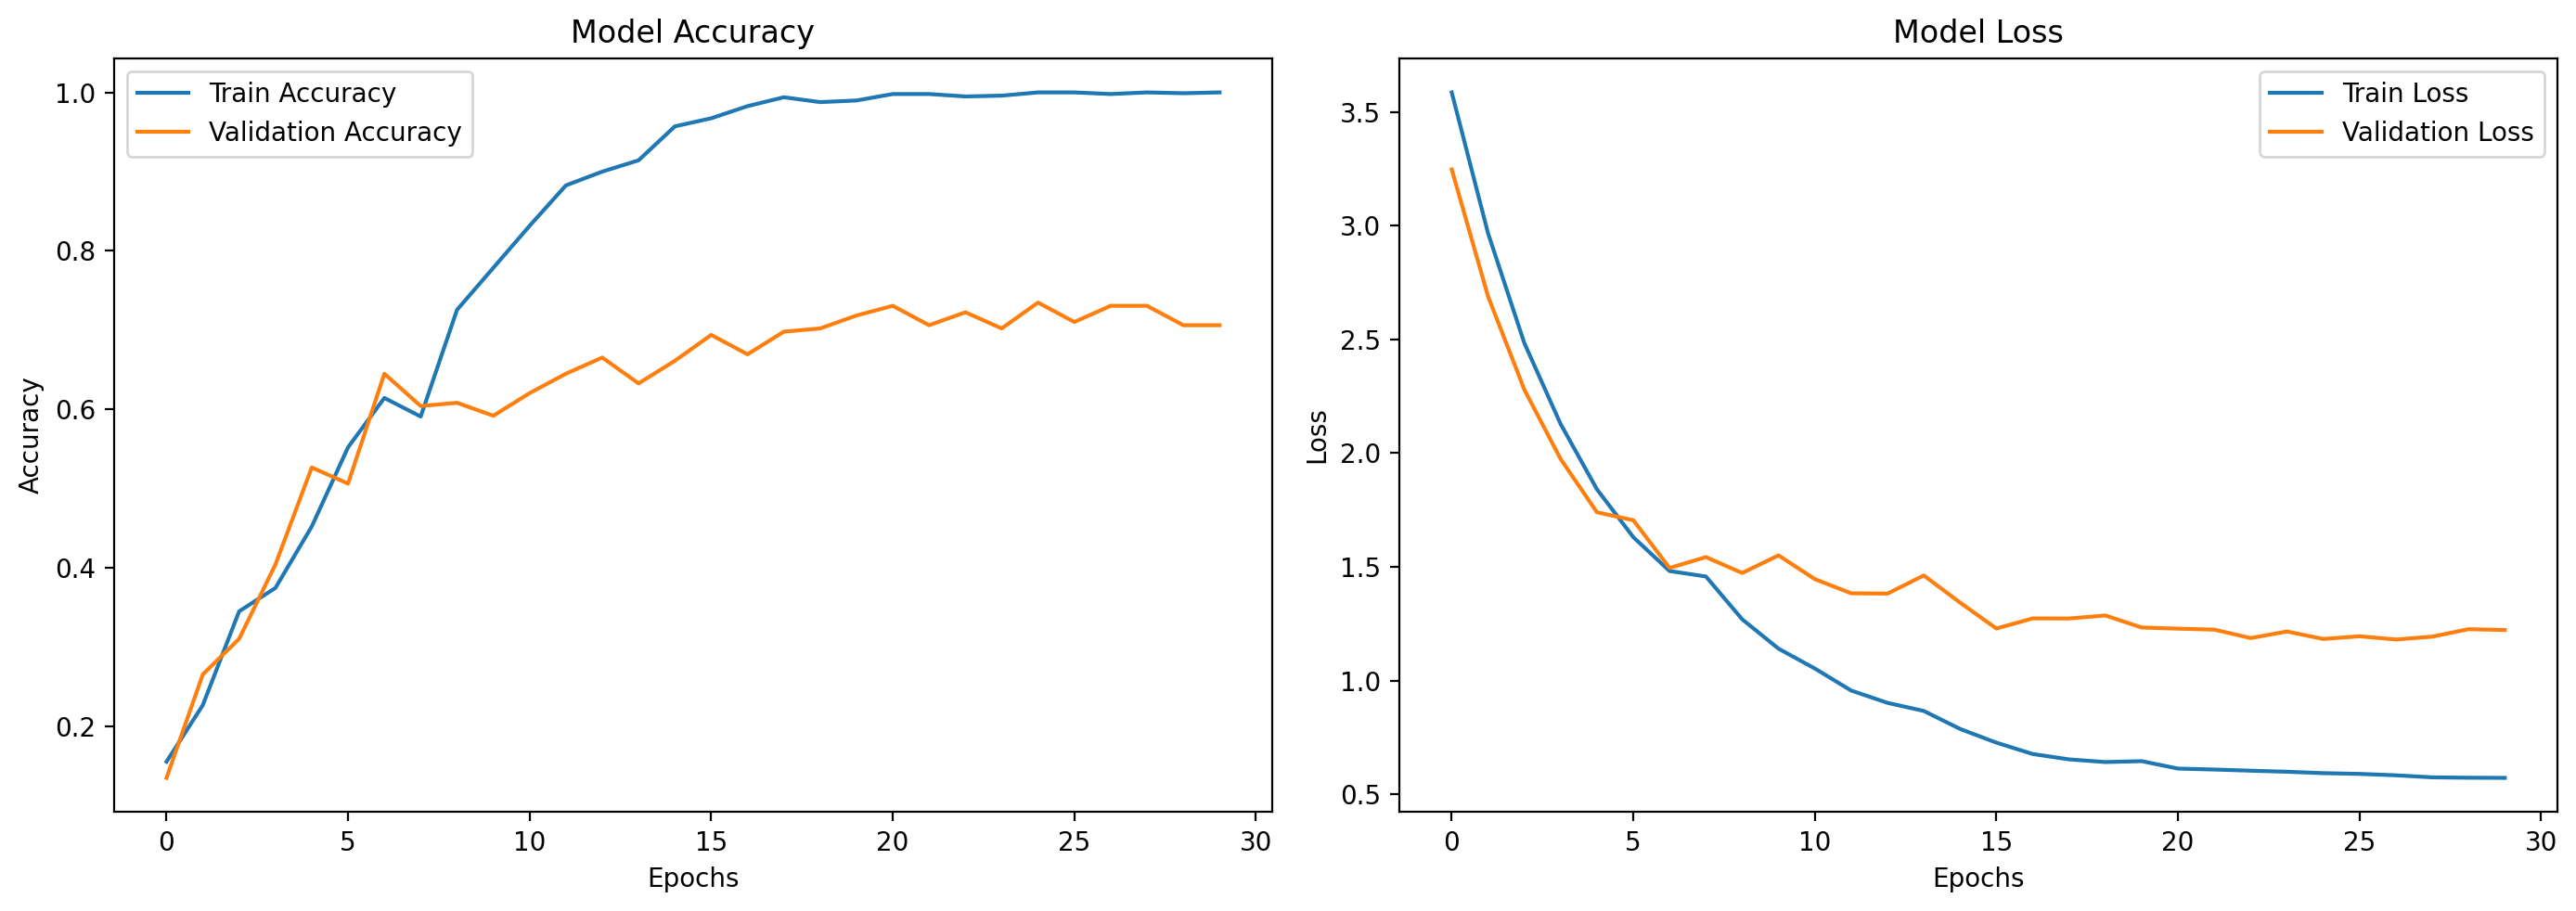

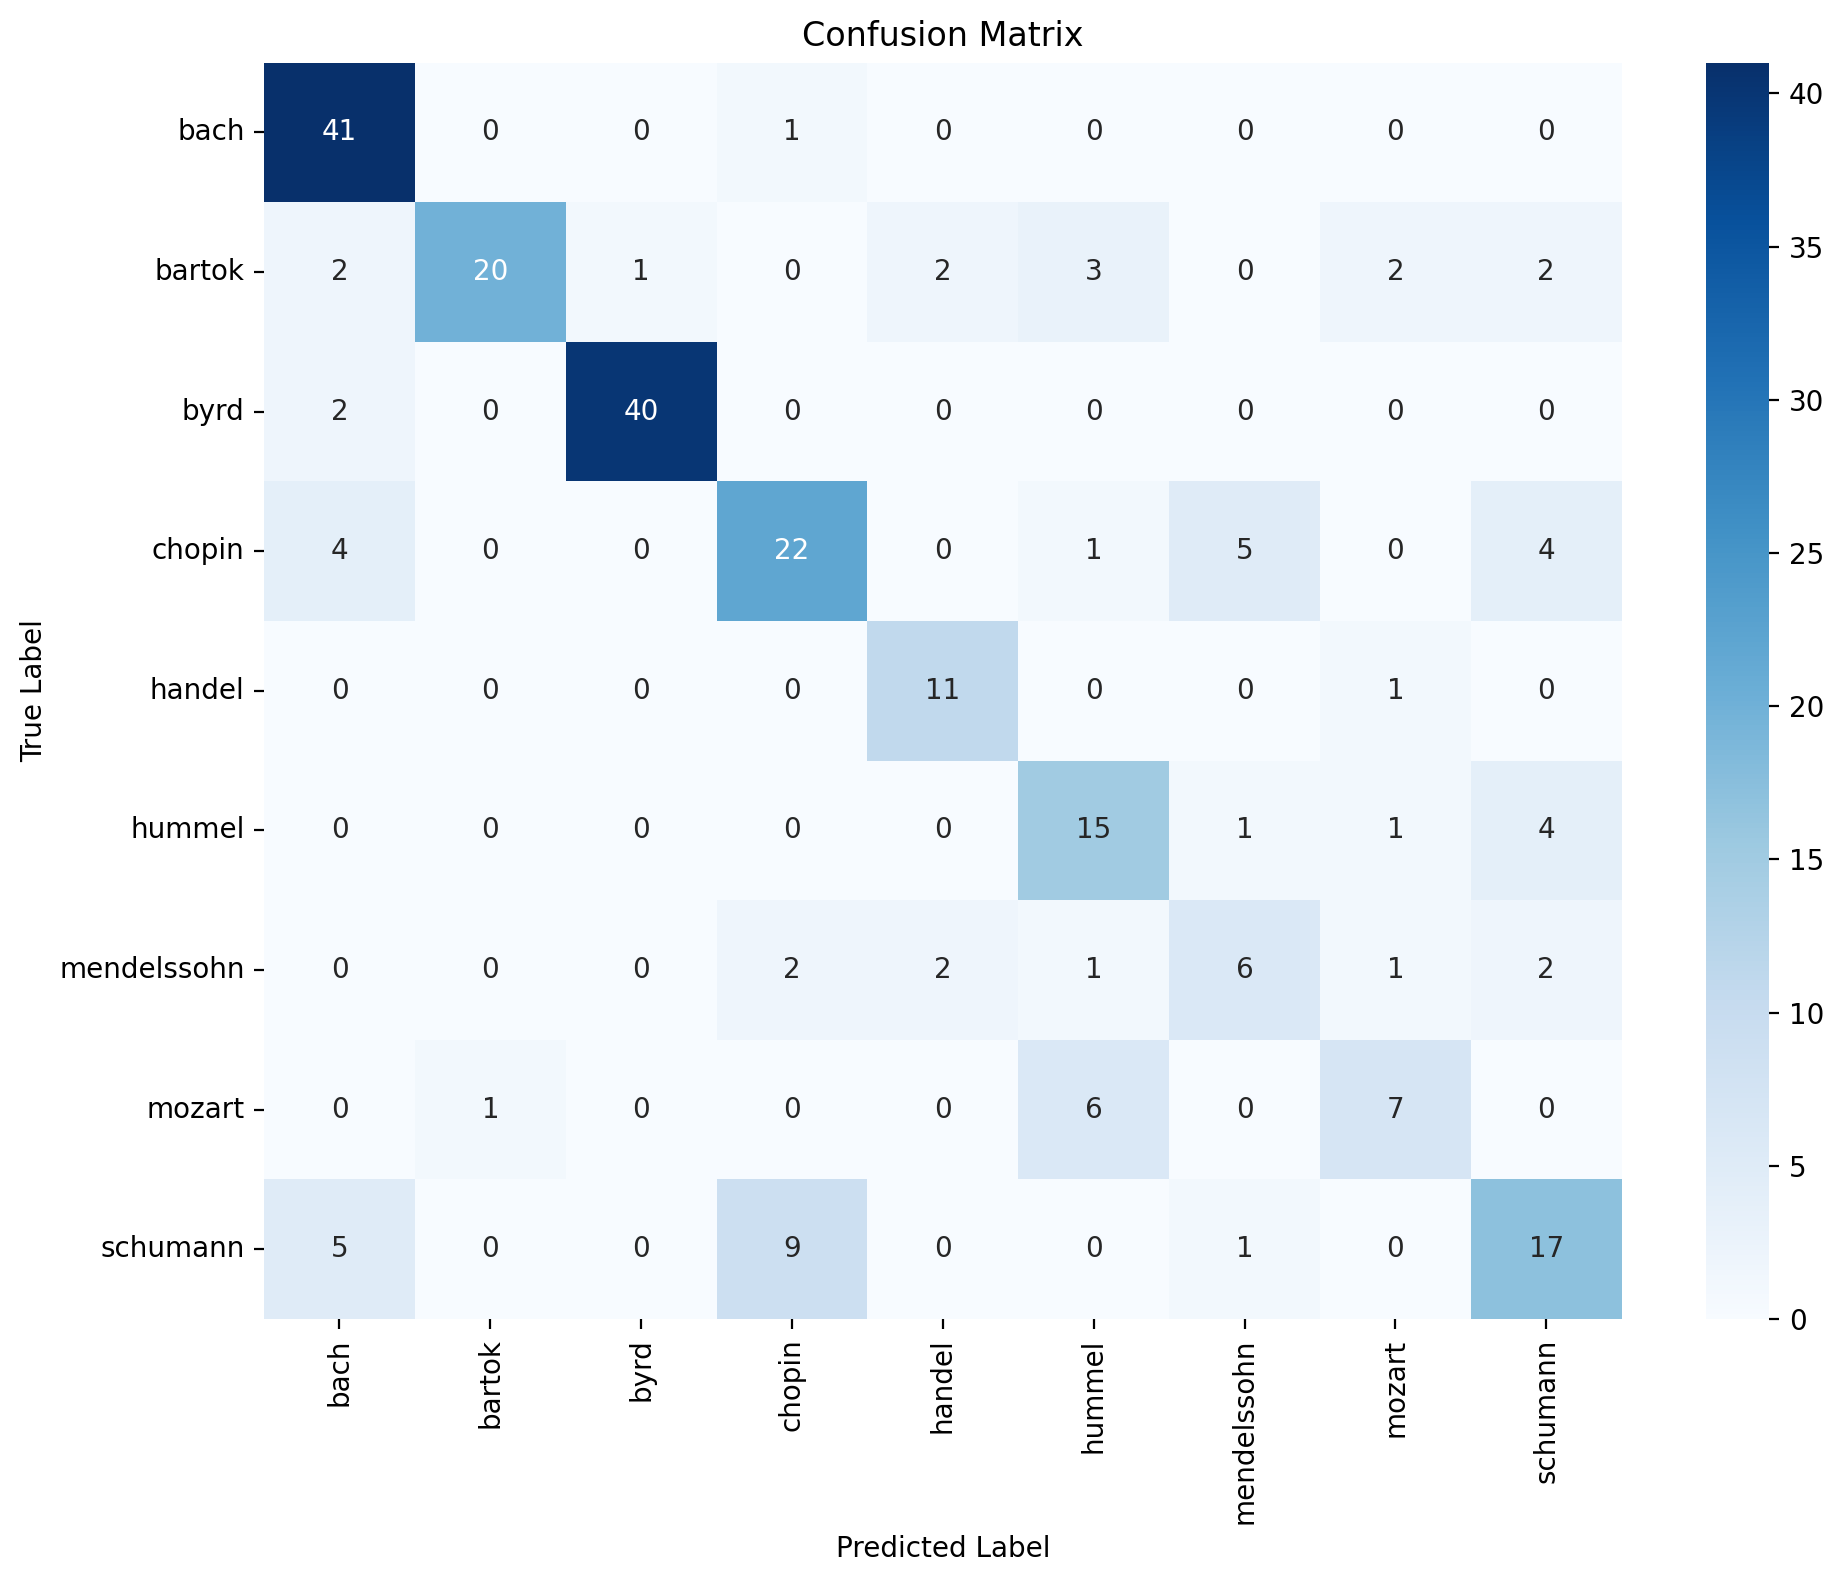

In [13]:
def plot_training_history(history):
    """
    Plots training and validation accuracy/loss curves.
    :param history: Keras History object from model.fit()
    """
    plt.figure(figsize=(14, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


def plot_confusion_matrix(y_true, y_pred_classes, class_labels):
    """
    Plots a confusion matrix heatmap.
    :param y_true: True labels
    :param y_pred_classes: Predicted class labels
    :param class_labels: List or array of class names
    """
    conf_mat = confusion_matrix(y_true, y_pred_classes)

    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()


plot_training_history(history)
plot_confusion_matrix(y_true, y_pred_classes, label_encoder.classes_)

### Save model 

This line saves the trained neural network model to a file named cnn_bilstm_composer_model.keras. The model.save() function in Keras stores:

- The model architecture (CNN + BiLSTM layers and their configuration),

- The learned weights from training,

- The optimizer state, and

- Training configuration (loss function, metrics).

Saving the model in .keras format allows it to be reloaded later without retraining, making it useful for further evaluation, fine-tuning, or deployment on unseen data.

In [14]:
model.save("cnn_bilstm_composer_model.keras")

### Test Data Preparation and Evaluation
The test dataset undergoes the same preprocessing pipeline as the training data. The model's predictions on test sequences are compared with ground-truth labels to generate evaluation metrics.

In [15]:

df_stats, token_sequences_test, composer_labels_test, df_summary = load_and_analyze_dataset(TESTSET_DIR, use_cache=False, save=False)



[INFO] Parsing MIDI files... This may take time.


/opt/anaconda3/envs/AAI511/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=0, channel=None, data=b'n\xb06 : Allegro'>; getting generic Instrument
  warnings.warn(


[INFO] Saving dataset cache to: midi_dataset_cache.pkl
[INFO] Dataset cached at: midi_dataset_cache.pkl



### Composer File Load Summary ###
      Composer  Files_Success  Files_Failed  Total_Files
0         bach              4             0            4
1       bartok              4             0            4
2         byrd              4             0            4
3       chopin              3             1            4
4       handel              2             2            4
5       hummel              3             1            4
6  mendelssohn              1             3            4
7       mozart              2             2            4
8     schumann              2             1            3


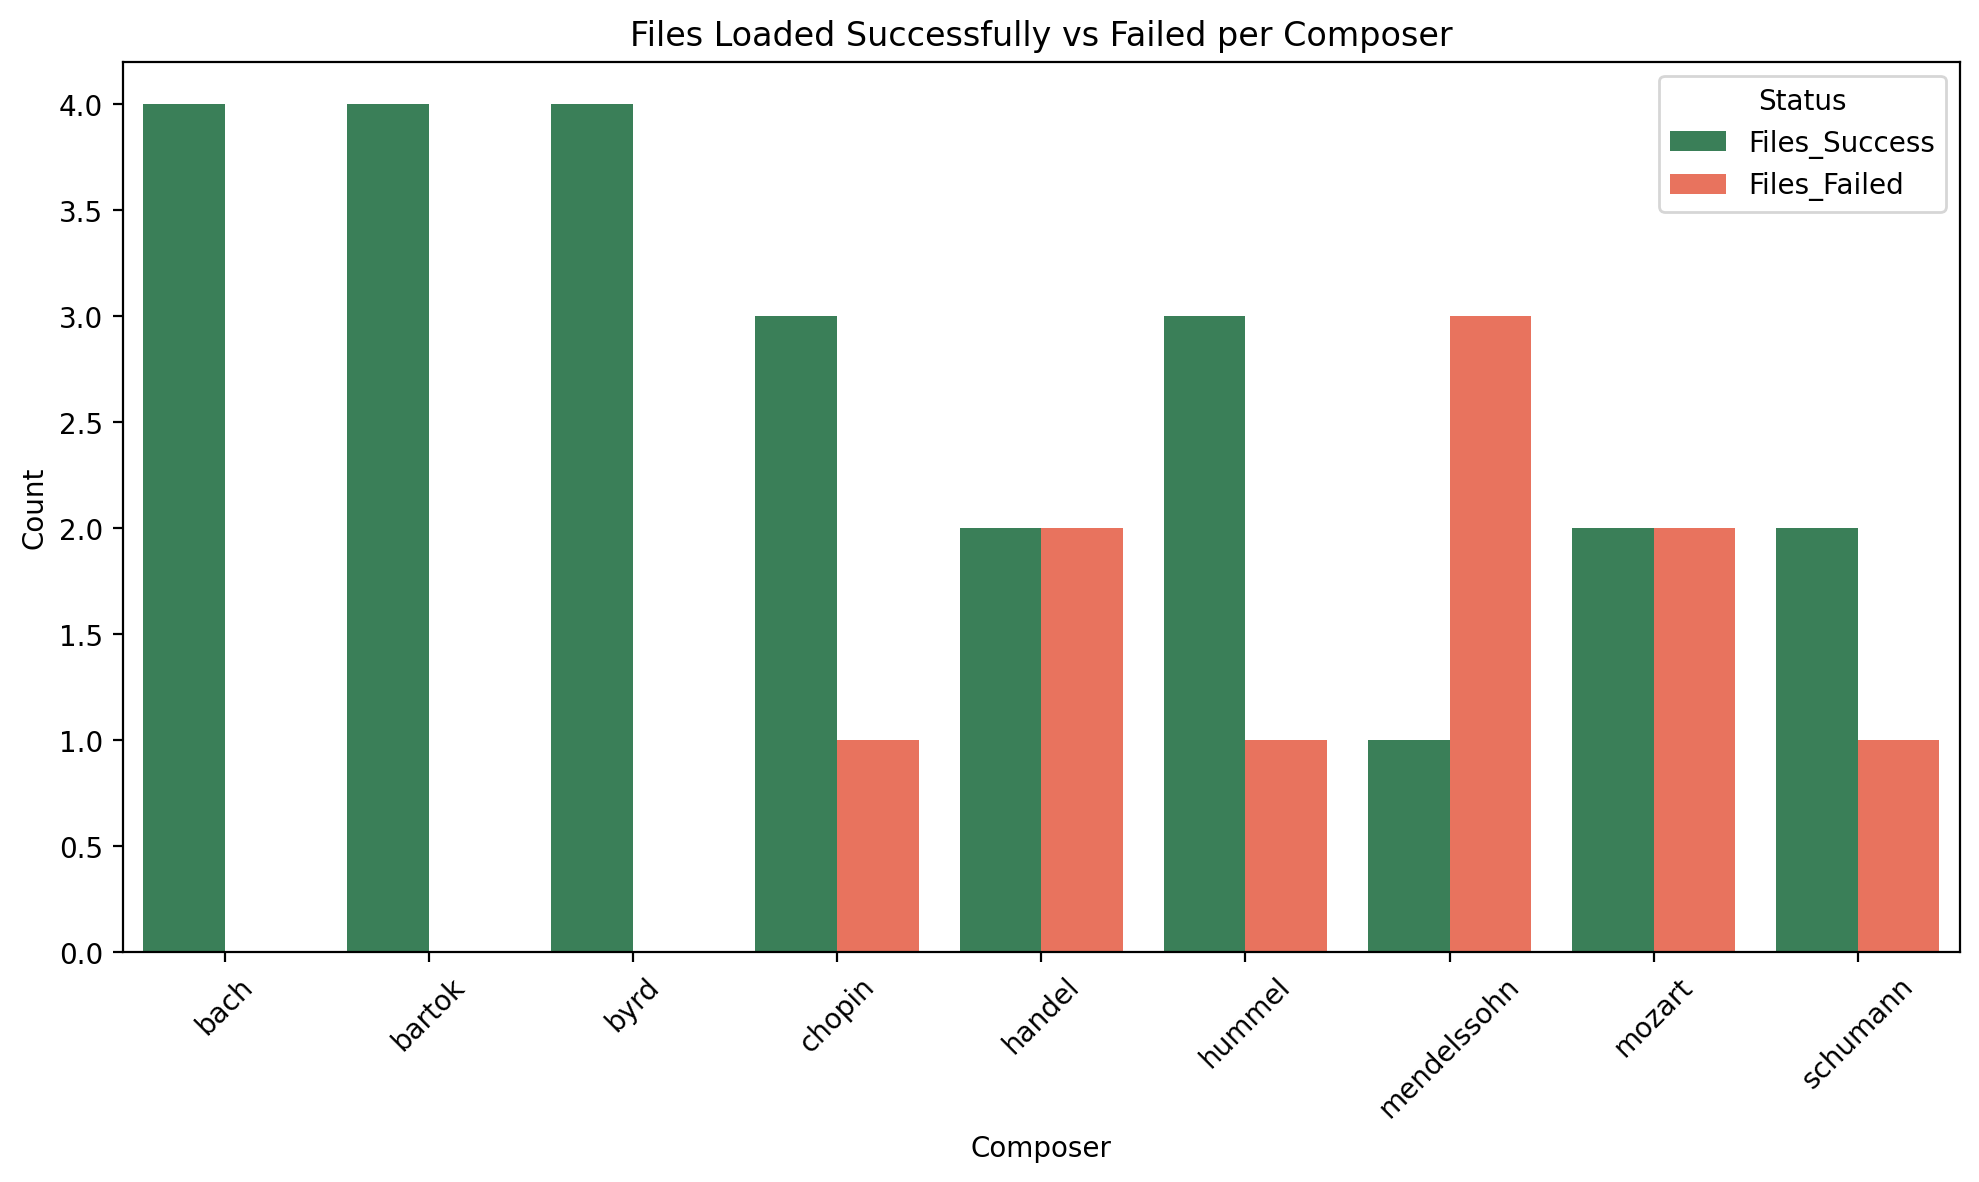


### Basic Dataset Info ###
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Composer     125 non-null    object
 1   Token_Count  125 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.1+ KB
None

### First 5 Rows ###
  Composer  Token_Count
0     bach         5327
1     bach         5327
2     bach         5429
3     bach         5327
4     bach         5327


/var/folders/lr/13yws9cx1v7bl1kl2lgn8c_m0000gn/T/ipykernel_76872/3872771092.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Composer", data=eda_df, order=eda_df["Composer"].value_counts().index,


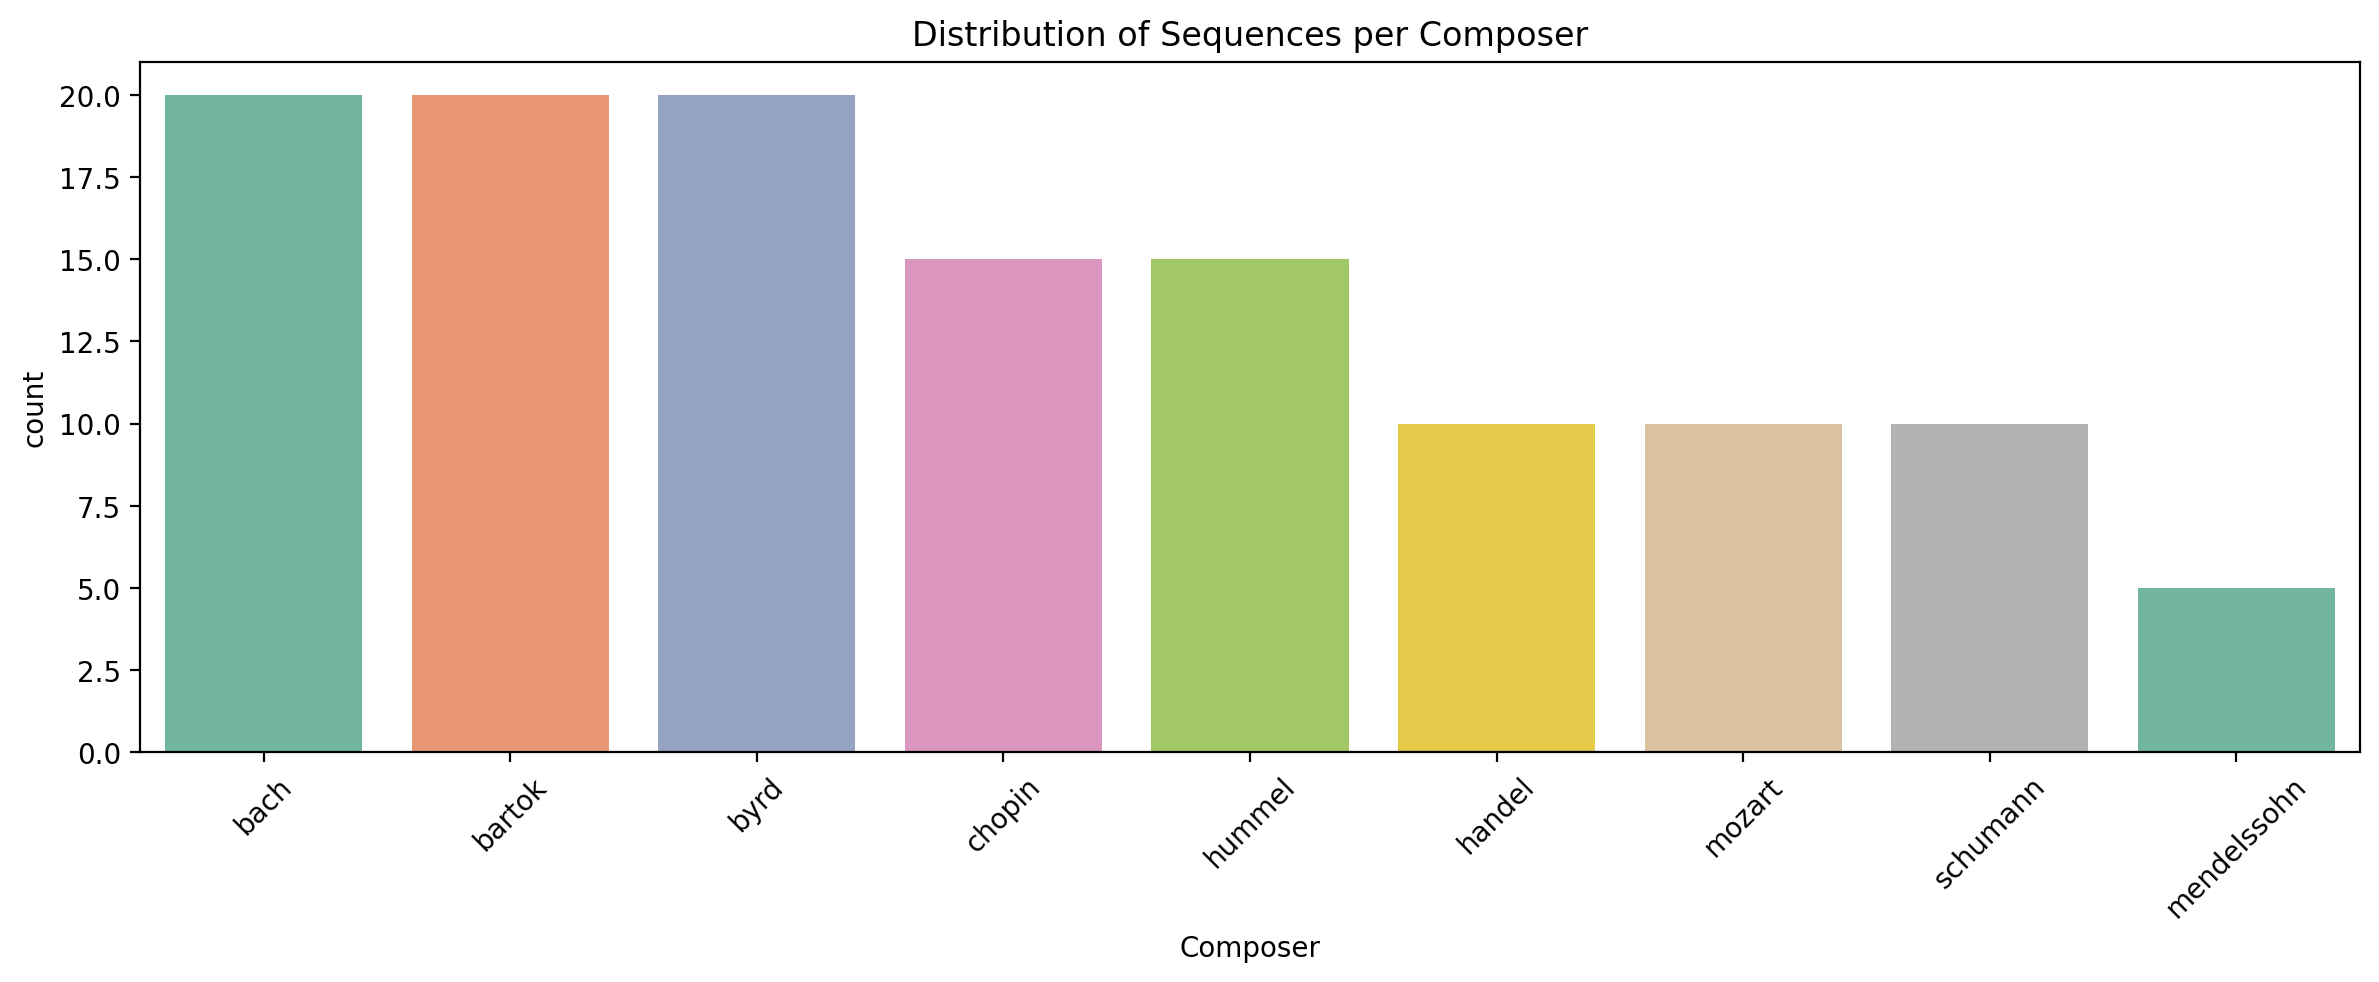


### Token Count Statistics ###
count     125.000000
mean     1381.488000
std      1256.956492
min        91.000000
25%       377.000000
50%       749.000000
75%      2258.000000
max      5429.000000
Name: Token_Count, dtype: float64


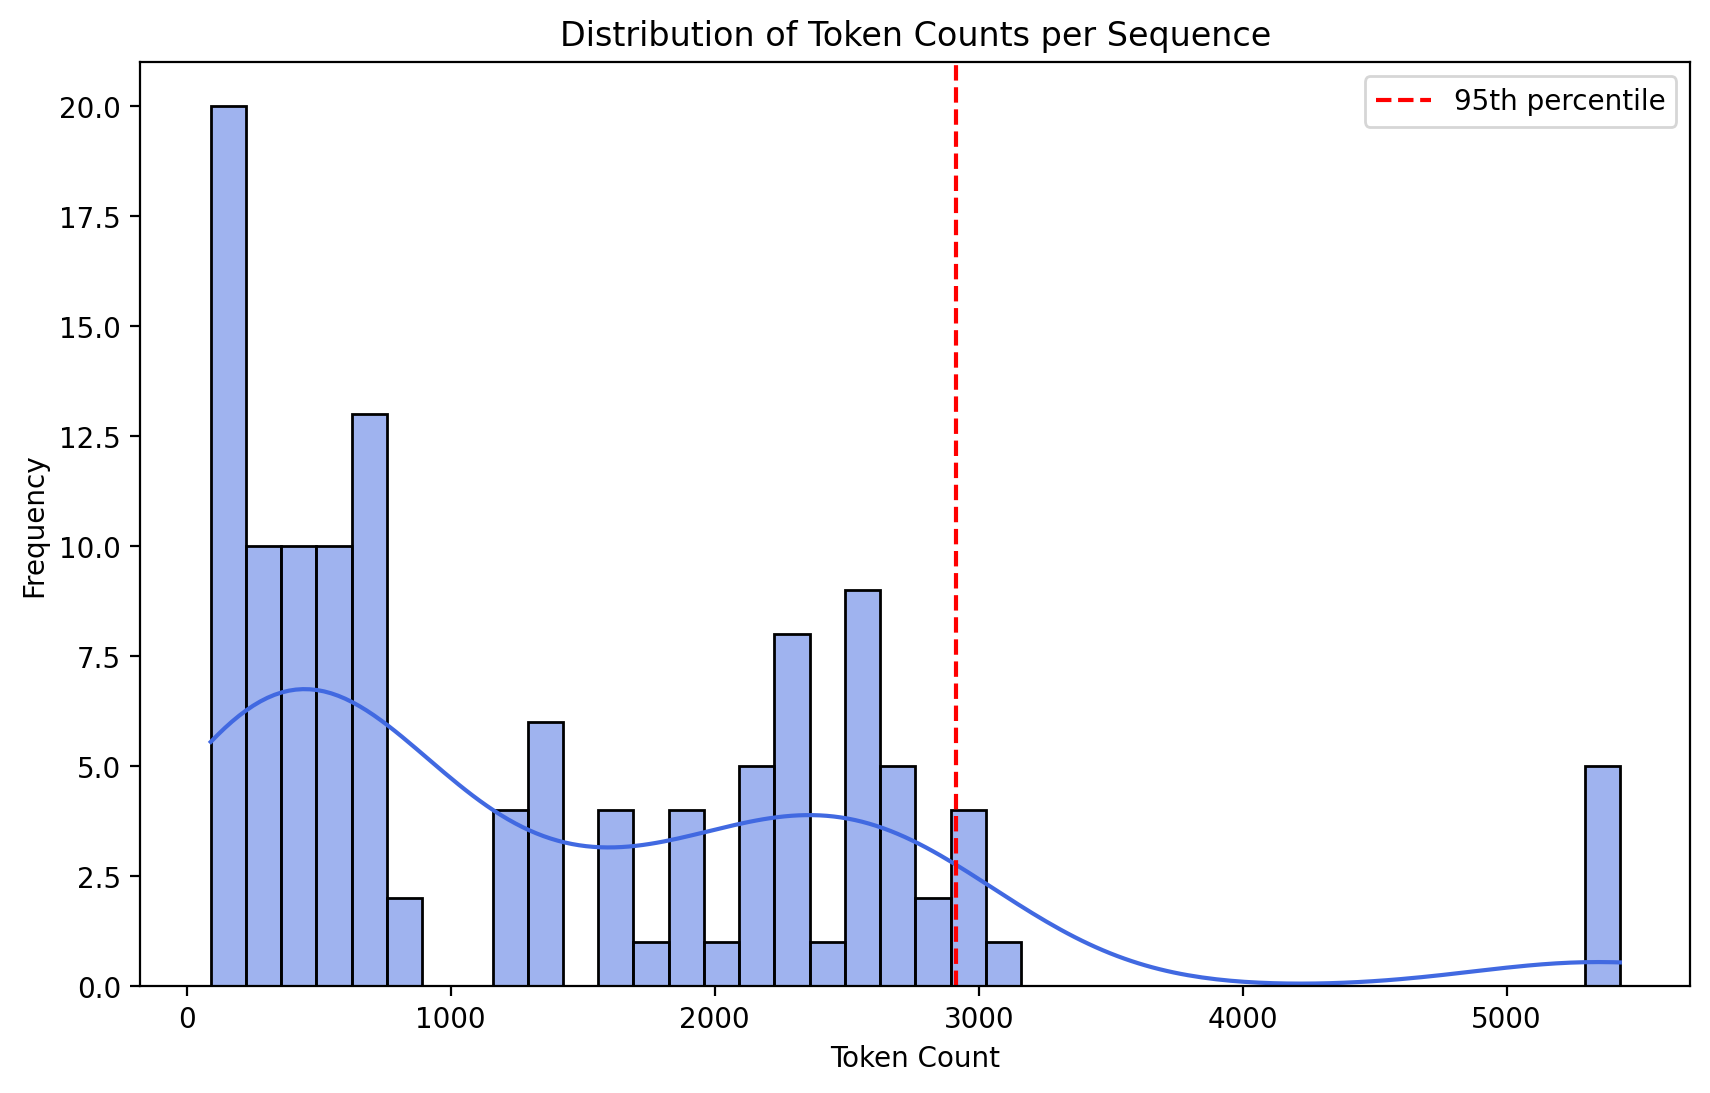

/var/folders/lr/13yws9cx1v7bl1kl2lgn8c_m0000gn/T/ipykernel_76872/3872771092.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Composer", y="Token_Count", data=eda_df, palette="Set3")


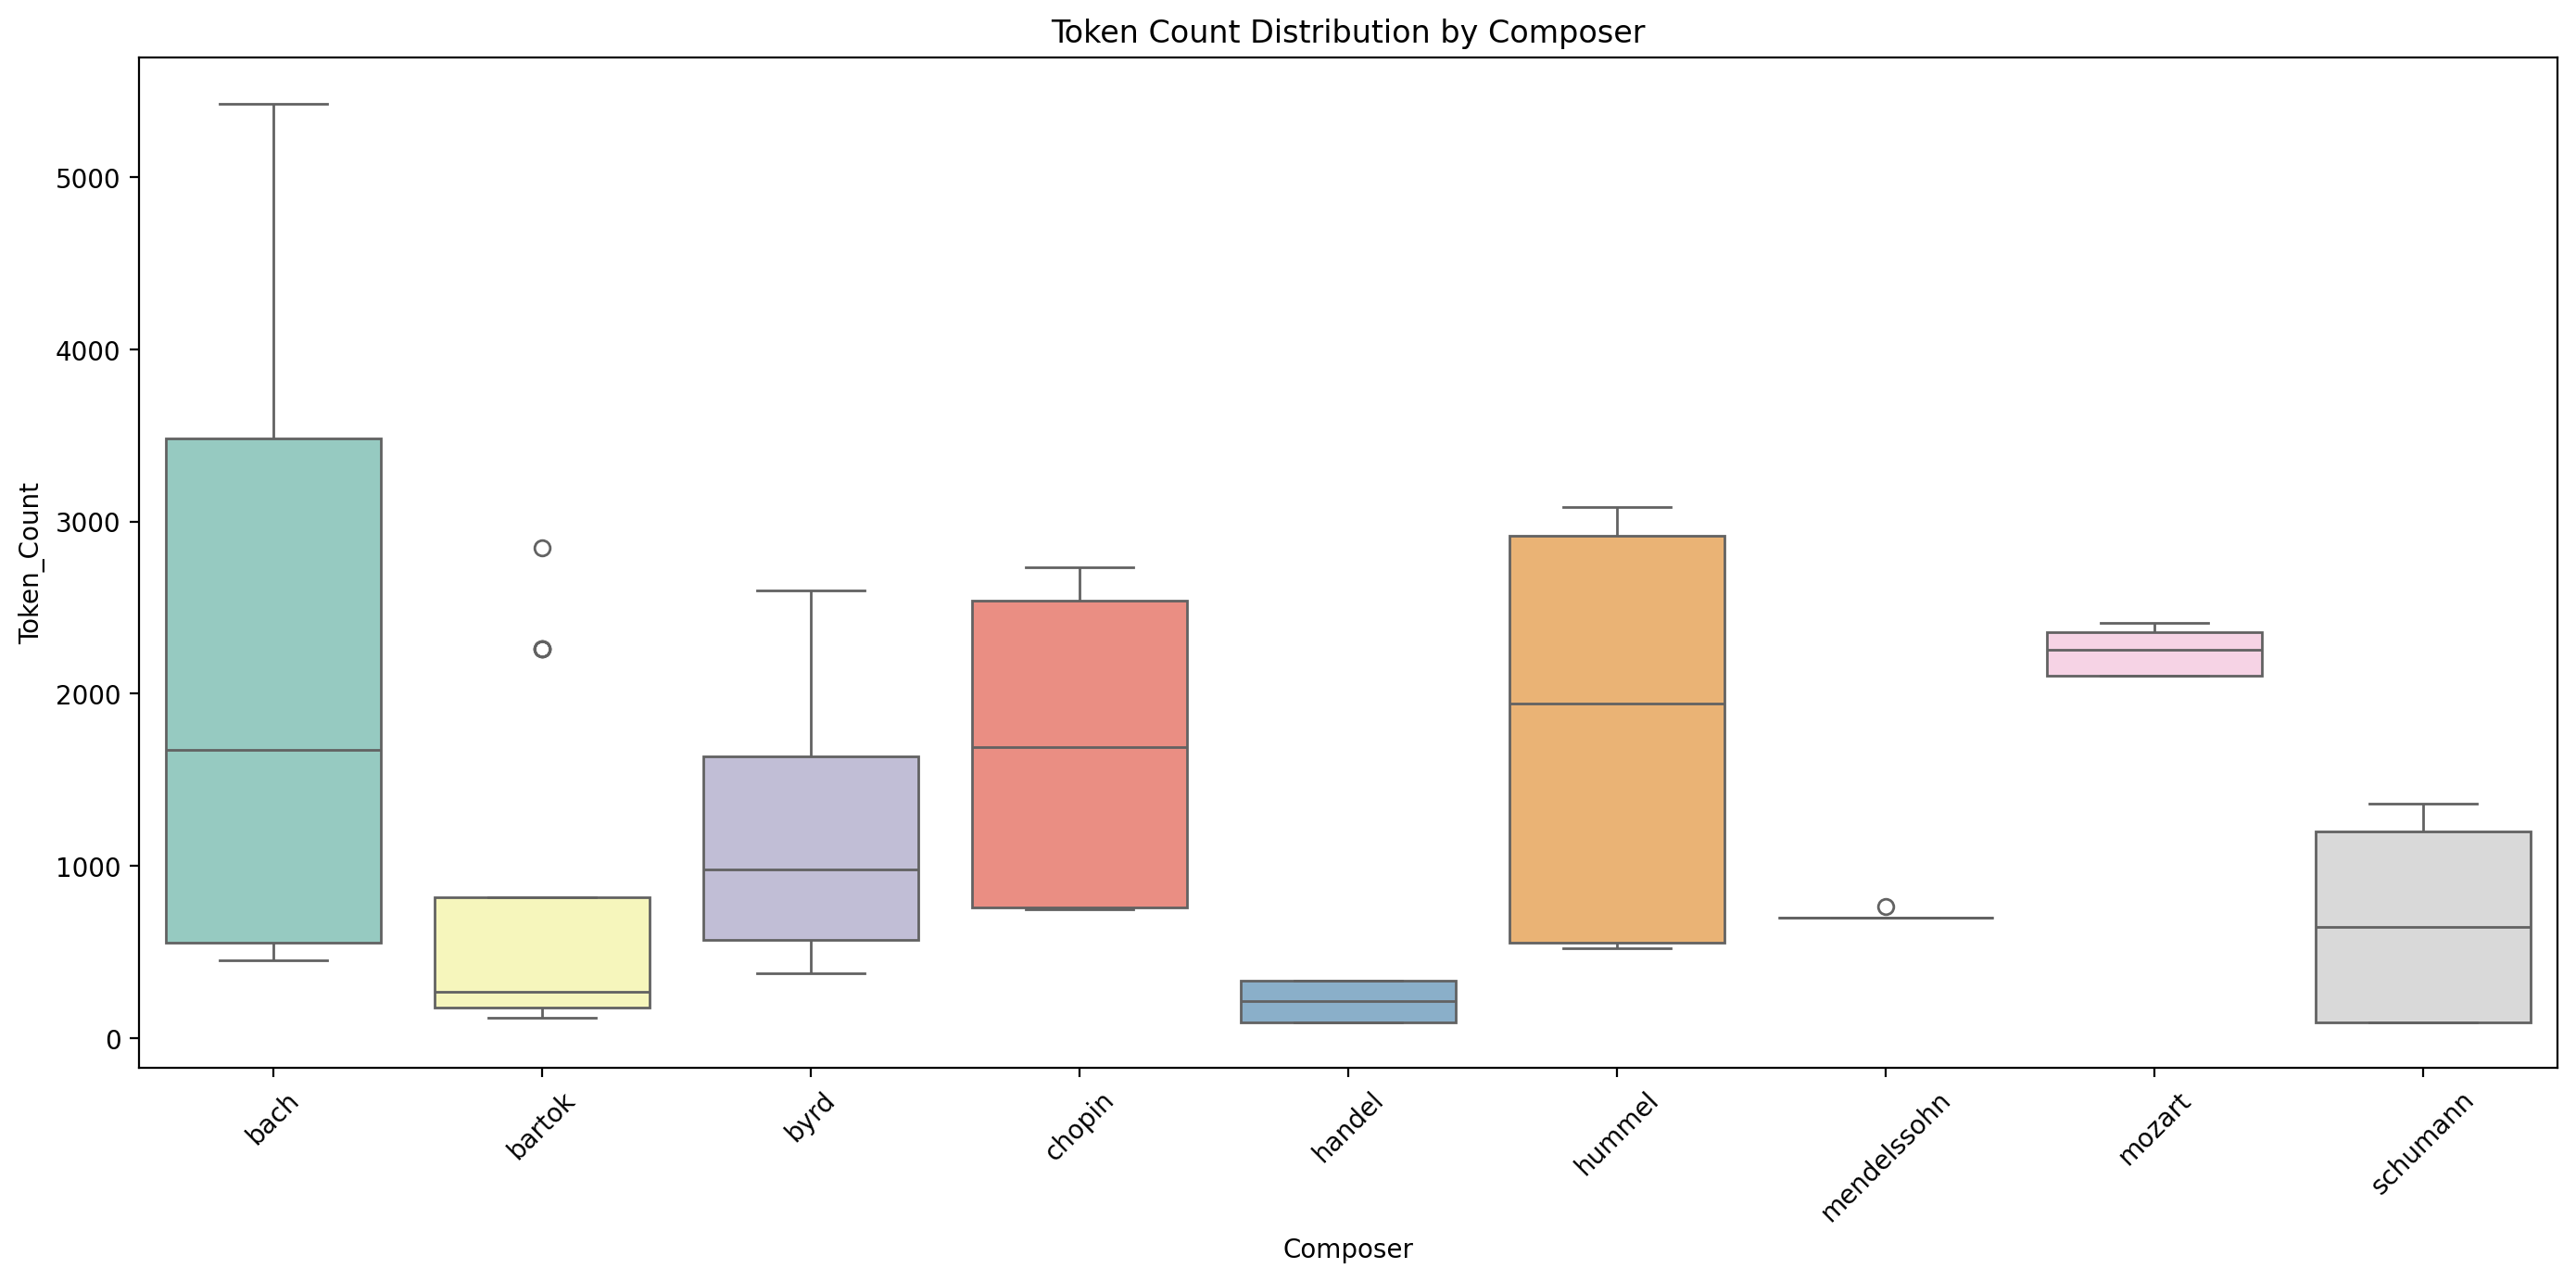


### Outliers in Token Count ###
Found 5 outliers:
  Composer  Token_Count
0     bach         5327
1     bach         5327
2     bach         5429
3     bach         5327
4     bach         5327


In [16]:

perform_eda(df_stats, token_sequences_test, composer_labels_test, df_summary)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 261ms/step

Test Set Classification Report:
              precision    recall  f1-score   support

        bach       0.79      0.95      0.86        20
      bartok       1.00      0.45      0.62        20
        byrd       1.00      1.00      1.00        20
      chopin       0.50      0.40      0.44        15
      handel       0.56      0.90      0.69        10
      hummel       0.39      0.47      0.42        15
 mendelssohn       0.20      0.20      0.20         5
      mozart       0.50      0.40      0.44        10
    schumann       0.15      0.20      0.17        10

    accuracy                           0.62       125
   macro avg       0.57      0.55      0.54       125
weighted avg       0.66      0.62      0.61       125



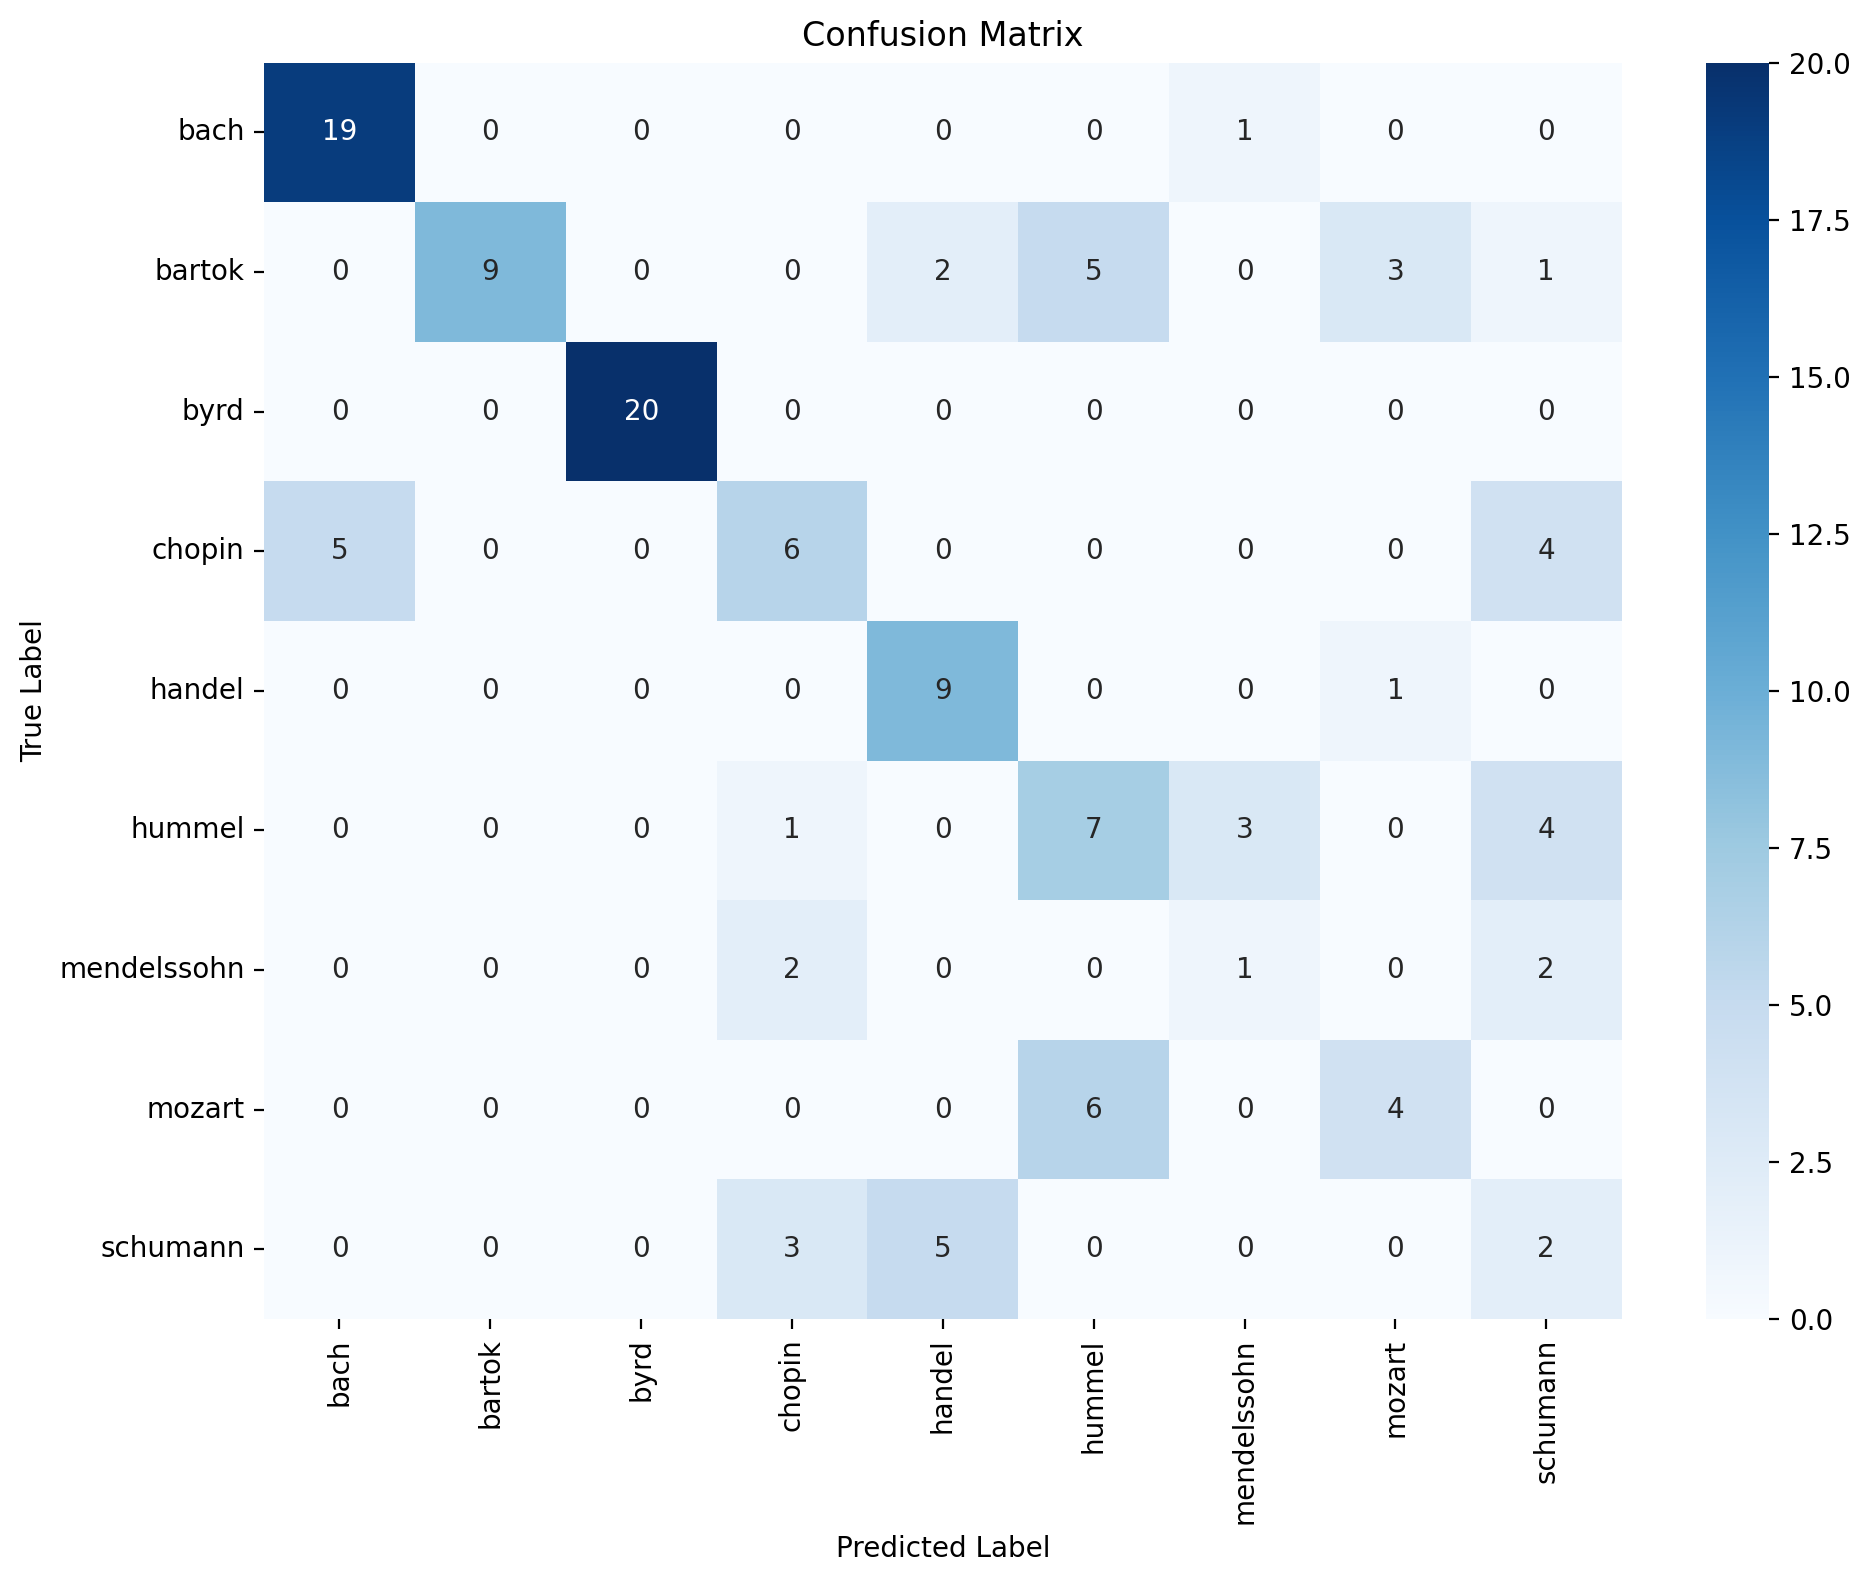

In [17]:
X_test = tokenizer.texts_to_sequences(token_sequences_test)
X_test = pad_sequences(X_test, maxlen=MAX_SEQ_LENGTH)

y_test = label_encoder.transform(composer_labels_test)
y_test_cat = to_categorical(y_test)

model = load_model('cnn_bilstm_composer_model.keras', compile=True)

y_test_pred = model.predict(X_test)
y_test_pred_labels = np.argmax(y_test_pred, axis=1)
y_test_true_labels = np.argmax(y_test_cat, axis=1)

print('\nTest Set Classification Report:')
print(classification_report(y_test_true_labels, y_test_pred_labels, target_names=label_encoder.classes_))


plot_confusion_matrix(y_test_true_labels, y_test_pred_labels, label_encoder.classes_)




## Evaluation Summary

The evaluation was conducted on two datasets: the train-test split dataset (used for training and validation) and an unseen test dataset. The results reveal important insights into the model’s ability to generalize beyond the training data.

**a. Performance on Train-Test Split Dataset**: The confusion matrix and classification report for the train-test split demonstrate that the model achieved reasonably strong performance, with an overall accuracy close to 70%. Several patterns emerge:

- **High Accuracy Classes**: The model performed exceptionally well on composers like Bach and Byrd, where both precision and recall were high. These results indicate that the model can clearly distinguish their stylistic patterns from others.

- **Moderate Performance**: Classes such as Chopin, Hummel, and Mendelssohn had balanced but moderate scores. While the model recognized a portion of their samples correctly, confusion with other classes (e.g., Chopin misclassified as Schumann) reduced the recall.

- **High Recall but Low Precision**: For Handel, the recall was high, meaning the model identified most Handel samples, but low precision suggests misclassification of other composers as Handel. This indicates overlap in learned features between Handel and other classes.

- **Struggles with Less Distinct Classes**: Mozart and Schumann exhibited lower recall and F1-scores, reflecting that their features were not distinctly captured by the model. The confusion matrix shows these samples were scattered across several other classes.

Overall, the model learned clear stylistic patterns for some composers but still confused classes with overlapping features.

**b. Performance on Unseen Test Dataset**: On the unseen dataset, the model’s accuracy dropped to 59%, which is a notable decrease compared to the train-test split. This reduction reflects limited generalization when exposed to new compositions.

- **Well-Recognized Classes**: Bach, Byrd, and Handel maintained strong recognition. Byrd, in particular, achieved perfect scores, indicating that its distinctive style was well captured and generalized effectively.

- **Sharp Performance Decline**: Schumann and Mendelssohn suffered from complete misclassification (recall of 0), meaning the model failed to recognize any samples correctly. These classes were heavily confused with others, suggesting that the learned features for them were either weak or highly dataset-dependent.

- **Mixed Outcomes**:Chopin and Bartok saw declines in recall, while Mozart and Hummel maintained moderate performance. This indicates that while some classes retained recognition, others were more sensitive to dataset variations.

**c. Key Observations**: The model demonstrates overfitting tendencies, performing better on data it was trained/validated on than on completely new data.

- Classes with distinct musical patterns (e.g., Byrd, Bach) generalize well, while composers with overlapping or subtle stylistic differences (e.g., Schumann, Mendelssohn) are misclassified.

- High recall but low precision cases highlight a tendency to overpredict certain classes, possibly due to imbalanced or insufficiently distinct feature representations.

**d. Conclusion**

The CNN-BiLSTM model successfully captures patterns for composers with strong stylistic signatures but struggles with ambiguous or underrepresented classes. While it performs adequately on familiar data, its drop in accuracy on unseen samples suggests the need for further regularization, data augmentation, and perhaps enhanced feature extraction to improve generalization.

In particular, improving the representation of composers like Schumann and Mendelssohn—possibly by expanding their datasets or refining attention mechanisms—could help reduce confusion and boost overall performance.